<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 8 Tutorial: Generalised Additive Models</h2>
<br>

In this notebook, we study how to train regression splines and generalised additive models using Python.

<a class="buttom" href="#1.-Customer-analytics-data">Customer analytics data</a> <br>
<a class="buttom" href="#2.-Some-EDA">Some EDA</a> <br>
<a class="buttom" href="#3.-Regression-Splines">Regression Splines</a> <br>
<a class="buttom" href="#4.-Generalised-additive-model">Generalised additive model</a> <br>
<a class="buttom" href="#5.-Validation-results">Validation results</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Requirements 

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygam
import sklearn
import optuna

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'pygam {pygam.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on: 

# numpy 1.22.2
# scipy 1.7.1
# pandas 1.3.4
# seaborn 0.11.2
# pygam 0.8.0
# scikit-learn 1.0.2
# optuna 2.10.0

Package versions: 

numpy 1.20.3
scipy 1.7.3
pandas 1.2.5
seaborn 0.11.1
pygam 0.8.0
scikit-learn 1.0.2
optuna 2.9.1


The next cell is optional configuration.

In [2]:
# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# 1. Customer Analytics Data 

The dataset for this tutorial is from customer analytics.  A key task in customer analytics is to predict the profitability of a customer, which involves both classification and regression tasks. We can apply classification methods to predict whether a customer will be acquired and retained, and regression methods to estimate the profitability of acquired and retained customers.

We focus on the regression task, though a more complete model can include all parts of the customer cycle. We will predict the customer lifetime value (CLV, a measure of profitability), taking into account some of the nonlinearities in the data.

The data is from a company that does business-to-business (B2B) sales. 

In [3]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121



The response variable is thus the CLV of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the `Censor` variable.

In [4]:
data = data[data['Censor'] == 1] # our goal is to predict the CLV of retained customers, identified by Censor=1 

The predictors are dollars spent on acquiring and retaining the client, the value of the first purchase, revenue and number of employees of the client, the number of product categories which the customer purchased, the number of purchase occasions, and the industry the client belongs to.

In [5]:
response = ['CLV']

continuous = ['Acq_Expense', 'Ret_Expense', 'First_Purchase', 'Revenue', 'Employees']
discrete = ['Frequency', 'Crossbuy']
binary = ['Industry']

predictors = continuous + discrete + binary
    
data = data[response + predictors] # keeping only the variables that we are going to use

We split the data into training (70%) and validation (30%) sets before proceeding. 

In [6]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_valid = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and validation sets 
train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

y_train= train['CLV'].to_numpy()
y_valid = valid['CLV'].to_numpy()

It will be useful to standardise the numerical features.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train.loc[:, continuous + discrete] = scaler.fit_transform(train.loc[:, continuous + discrete])
valid.loc[:, continuous + discrete] = scaler.transform(valid.loc[:, continuous + discrete])

X_train = train[predictors]
X_valid = valid[predictors]

# 2. Some EDA

We relied on automated EDA a few times in previous tutorials. These are great tools that can save you time, but as you get more programming experience, I suggest that you also start developing your personal library of EDA functions.  You can then customise all the tables and plots according to your needs and export the results to include in a presentation or report.

Another reason for doing is this is that automated EDA struggles with large datasets.

Below, we code a function to visualise the relationship between the response and each of the inputs. Skip ahead to see the desired result, and then go back to understand the code.  

In [8]:
X = train[predictors]
X.head()

,Acq_Expense,Ret_Expense,First_Purchase,Revenue,Employees,Frequency,Crossbuy,Industry
Customer,,,,,,,,
350,0.026731,-0.941970,-1.468372,-1.692956,-1.079390,-0.291015,-0.369002,1
317,0.271786,0.082344,0.699330,1.544606,0.160913,-0.291015,0.218900,1
337,-0.423261,0.434920,0.533899,-0.509739,0.899188,-0.739463,1.394704,0
467,-0.982885,1.146038,-0.457309,-1.310067,-0.098960,-1.636360,-1.544806,0
184,0.776435,1.553852,0.254340,0.010786,0.095944,0.830107,1.394704,1


In [9]:
def plotregressions(X, y, lowess=False):
    # X should be a pandas dataframe
    
    colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
               '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    # Feature names
    labels = list(X.columns)
    
    n, p = X.shape
    
    # We want three plots per column, calculate the required number of rows accordingly
    rows = int(np.ceil(p/3)) 
    
    # Create a plot grid
    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))
    
    # Loop over the plot grid, create 
    for i, ax in enumerate(fig.axes):
        if i < p:
            
            # Scatter plot with local smoothing
            sns.regplot(X.iloc[:, i], y,  ci=None, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.8}, ax=ax, lowess=lowess, color=colours[i % 10])
            
            # Remove axis labels to de-clutter the plot
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            # Manually set the limits for the horizontal axis since the default doesn't work so well
            xmin = X.iloc[:,i].min()
            xmax = X.iloc[:,i].max()
            ax.set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax - xmin)*0.05)
            
            # Use the feature name for the title
            ax.set_title(labels[i])
        
        else:
            # Delete unnecessary subplots (last row)
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

There seems to be some nonlinearity in the data, especially in the case of the retention expense.

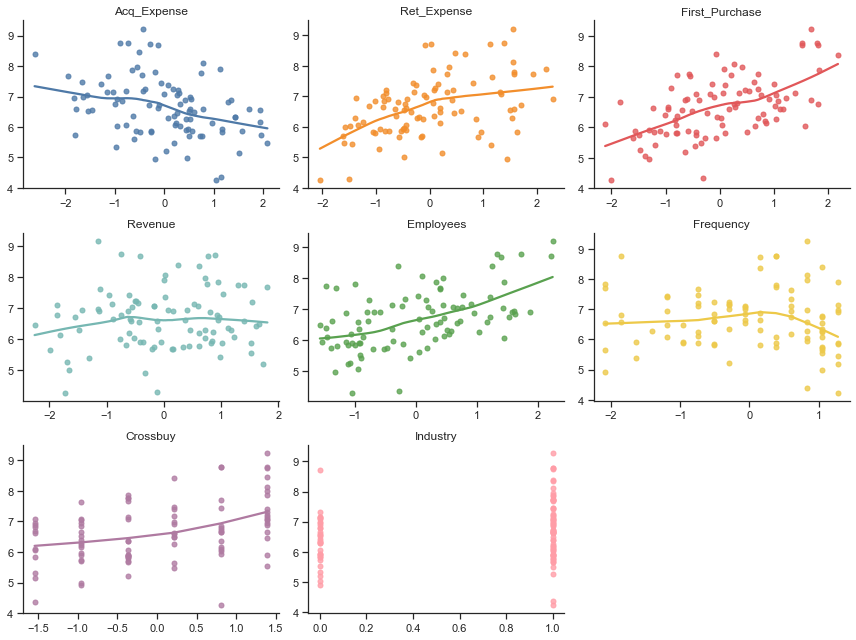

In [10]:
plotregressions(train[predictors], y_train, lowess=True)
plt.show()

# 3. Regression Splines

In this section, we'll focus on a single predictor to study regression splines.

## 3.1 Constructing spline representations


The next cell builds cubic spline basis expansions for retention expenses variable. The function uses basis functions called B-splines, rather than the exact spline functions defined in the lecture. B-splines generate an equivalent model but have better numerical properties. 

We specify that we want the cubic spline by setting `degree=3`. The `SplineTransformer` includes boundary knots, so `knots = 3`yields one interior knot. Setting `include_bias = False` deletes of one of features to avoid perfect multicollinearity when we fit the model with an intercept. 

In [19]:
from sklearn.preprocessing import SplineTransformer

spline = SplineTransformer(n_knots=3, degree=3, knots='uniform', include_bias=False)
# spline = SplineTransformer(n_knots=3, degree=1, knots='quantile', include_bias=False)
X = spline.fit_transform(train[['Ret_Expense']])

X.shape

(94, 4)

In [18]:
X.shape

(94, 5)

Given the design matrix, we estimate the model by OLS. 

In [77]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X, y_train)

LinearRegression()

We now plot the estimated model. To do this, we need to generate a grid of values for the feature and create the corresponding design matrix. 

In [78]:
from patsy import build_design_matrices

# Create a grid of values for the feature
xmin = train['Ret_Expense'].min()
xmax = train['Ret_Expense'].max()
x = np.linspace(xmin, xmax).reshape((-1, 1))

# Generate the spline representation
XX = spline.transform(x)
y_fitted = ols.predict(XX)

Finally, we plot the regression fit. 

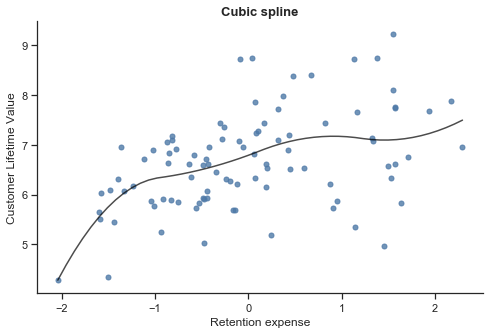

In [81]:
# Intialise figure
fig, ax = plt.subplots(figsize=(8,5))

# Scatter plot
sns.regplot(train['Ret_Expense'], y_train, scatter_kws={'s': 25}, fit_reg=False)

# Plot regression spline
ax.plot(x, y_fitted, color='Black', alpha=0.7)

# Plot labels
ax.set_xlabel('Retention expense')
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Cubic spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

The next cell repeats all these steps for a linear spline with two knots. You should experiment by changing the first two lines to try different models (say, by adding more knots and/or changing the polynomial degree) and trying different predictors.

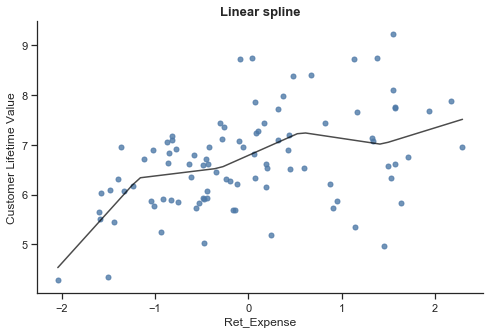

In [66]:
predictor = 'Ret_Expense'
spline = SplineTransformer(n_knots=6, degree=1, knots='uniform', include_bias=False)
X = spline.fit_transform(train[[predictor]])

ols = LinearRegression()
ols.fit(X, y_train)

xmin = train[predictor].min()
xmax = train[predictor].max()
x = np.linspace(xmin, xmax).reshape((-1, 1))

XX = spline.transform(x)
y_fitted=ols.predict(XX)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Linear spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## 3.2 Natural splines

The `SplineTransformer` is new to scikit-learn and does yet not support natural splines. Therefore, we need to switch to another method that has a slightly more complicated syntax. 

We use the [<TT>patsy</TT>](http://patsy.readthedocs.io/en/latest/index.html) library. The implementation is based on two core functions: [<TT>dmatrix</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrix), the general design matrix constructor, and [<TT>cr</TT>](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.cr), the building block for regression splines.

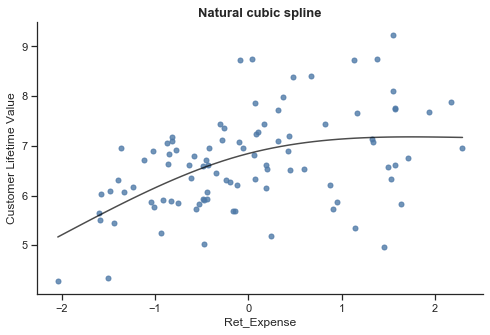

In [67]:
from patsy import dmatrix, build_design_matrices

predictor = 'Ret_Expense'
X = dmatrix('cr(variable, df=3) - 1', {'variable': train[predictor]})

ols = LinearRegression()
ols.fit(X, y_train)

xmin = train[predictor].min()
xmax = train[predictor].max()
x = np.linspace(xmin, xmax)

XX = build_design_matrices([X.design_info], {'variable': x})[0] 
y_fitted = ols.predict(XX)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

# 4. Generalised Additive Model


We use [pyGAM](https://pygam.readthedocs.io/en/latest/) to build a generalised additive model. 

This package follows an approach between smoothing splines and regression splines to fit the functions.  Like a smoothing spline, it uses a form of $\ell_2$ regularisation to penalise the roughness of the function. However, it uses a specified number of knots for the representation, like a regression spline. This is because having a knot for each data point, as in a smoothing spline, is computationally expensive and usually unnecessary.  

The next cell illustrates the syntax In pyGAM, `s` specifies a spline term, `l` a linear term, `f` a factor term (this corresponds to one-hot encoding of a discrete variable), and `te` a tensor product (an interaction term). 

Below, `s(0)` means that we model the first predictor (acquisition expense) using a spline term. `s(1, constraints='monotonic_inc')` means that we model the second predictor using a spline term constrained to be increasing (the value of the function can only increase if we increase the input).  You can also constrain the function to be decreasing, concave, or convex. `te(2, 3)` specifies an interaction between the third and fourth predictors.  

In [68]:
X_train.head()

,Acq_Expense,Ret_Expense,First_Purchase,Revenue,Employees,Frequency,Crossbuy,Industry
Customer,,,,,,,,
350,0.026731,-0.941970,-1.468372,-1.692956,-1.079390,-0.291015,-0.369002,1
317,0.271786,0.082344,0.699330,1.544606,0.160913,-0.291015,0.218900,1
337,-0.423261,0.434920,0.533899,-0.509739,0.899188,-0.739463,1.394704,0
467,-0.982885,1.146038,-0.457309,-1.310067,-0.098960,-1.636360,-1.544806,0
184,0.776435,1.553852,0.254340,0.010786,0.095944,0.830107,1.394704,1


In [83]:
# this is just an example!

from pygam import LinearGAM, s, f, l, te

gam = LinearGAM(s(0) + s(1, constraints='monotonic_inc') + te(2, 3) + s(4) + s(5) + f(6) + l(7))

In pyGAM, there's a different regularisation hyperparameter for each term. We need to set the penalties appropriately for this approach to make sense. 

We use Optuna for Bayesian hyperparameter optimisation. 

Two important details:

* We only use splines for the first two predictors (acquisition expense and retention expense). Using splines for the other predictors would cause overfitting.

* The model selection criterion is the generalised cross-validation (GCV) score. This is a computationally fast approximation to leave-one-out cross-validation that applies to this type of model. 

Running the optimisation for a couple of minutes should be enough to find a good configuration in this case. Note that Optuna makes your CPU work hard. In the assignment, you'd probably want to do this on Google Colab or another cloud service. 

In [70]:
predictors

['Acq_Expense',
 'Ret_Expense',
 'First_Purchase',
 'Revenue',
 'Employees',
 'Frequency',
 'Crossbuy',
 'Industry']

In [75]:
np.linspace(1, 10)  # Uniform

array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])

In [74]:
np.logspace(0, np.log10(10))  # Log-Uniform

array([ 1.        ,  1.04811313,  1.09854114,  1.1513954 ,  1.20679264,
        1.26485522,  1.32571137,  1.38949549,  1.45634848,  1.52641797,
        1.59985872,  1.67683294,  1.75751062,  1.84206997,  1.93069773,
        2.02358965,  2.12095089,  2.22299648,  2.32995181,  2.44205309,
        2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,
        3.23745754,  3.39322177,  3.55648031,  3.72759372,  3.90693994,
        4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,
        5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,
        6.55128557,  6.86648845,  7.19685673,  7.54312006,  7.90604321,
        8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])

In [84]:
predictors

['Acq_Expense',
 'Ret_Expense',
 'First_Purchase',
 'Revenue',
 'Employees',
 'Frequency',
 'Crossbuy',
 'Industry']

In [18]:
from optuna.samplers import TPESampler

def objective(trial):

    lambdas = []
    for j in range(len(predictors)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
    
    model = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7), lam=lambdas)
    model.fit(X_train, y_train)
    
    return model.statistics_['GCV']

sampler = TPESampler(seed=42)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='minimize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120) 

[I 2022-04-11 08:15:32,811] A new study created in memory with name: no-name-dc999cc2-5569-4566-b1f2-1b7d82d2cb8a
[I 2022-04-11 08:15:32,889] Trial 0 finished with value: 0.3453928514046138 and parameters: {'lambda_0': 0.09915644566638401, 'lambda_1': 4033.8008326003933, 'lambda_2': 71.77141927992021, 'lambda_3': 6.155564318973028, 'lambda_4': 0.0017707168643537846, 'lambda_5': 0.0017699302940633358, 'lambda_6': 0.00029152036385288323, 'lambda_7': 849.9808989183019}. Best is trial 0 with value: 0.3453928514046138.
[I 2022-04-11 08:15:32,918] Trial 1 finished with value: 0.1935933766687549 and parameters: {'lambda_0': 6.4405075539937195, 'lambda_1': 46.19347374377384, 'lambda_2': 0.00014610865886287216, 'lambda_3': 5744.851636320435, 'lambda_4': 456.6054873446131, 'lambda_5': 0.004997040685255816, 'lambda_6': 0.002848391870910803, 'lambda_7': 0.0029324868872723803}. Best is trial 1 with value: 0.1935933766687549.
[I 2022-04-11 08:15:32,953] Trial 2 finished with value: 0.270786967066617

[I 2022-04-11 08:15:33,524] Trial 20 finished with value: 0.23941051454663195 and parameters: {'lambda_0': 168.95920886334062, 'lambda_1': 924.5035653333086, 'lambda_2': 472.4865258754123, 'lambda_3': 23.009999557373703, 'lambda_4': 0.2091789545847377, 'lambda_5': 381.15206829363086, 'lambda_6': 0.22831281578996301, 'lambda_7': 3.013859131905251}. Best is trial 18 with value: 0.1920684834571452.
[I 2022-04-11 08:15:33,562] Trial 21 finished with value: 0.22439915507960947 and parameters: {'lambda_0': 1.5177079648776917, 'lambda_1': 11.877883947353947, 'lambda_2': 10.28347584313135, 'lambda_3': 0.2744924839537288, 'lambda_4': 18.333464833800054, 'lambda_5': 0.00382591600479689, 'lambda_6': 50.65472979376169, 'lambda_7': 0.15177668122780347}. Best is trial 18 with value: 0.1920684834571452.
[I 2022-04-11 08:15:33,593] Trial 22 finished with value: 0.1935276734783939 and parameters: {'lambda_0': 226.79948903951384, 'lambda_1': 760.5081427267228, 'lambda_2': 0.3725547479609094, 'lambda_3':

[I 2022-04-11 08:15:34,170] Trial 40 finished with value: 0.18064537496621647 and parameters: {'lambda_0': 675.166410475667, 'lambda_1': 66.53761723232398, 'lambda_2': 0.006850499601270697, 'lambda_3': 0.029922485535286508, 'lambda_4': 1.6602092550179912, 'lambda_5': 0.03637443610003338, 'lambda_6': 5.707602346130713, 'lambda_7': 0.007163030348928944}. Best is trial 35 with value: 0.17972408744636317.
[I 2022-04-11 08:15:34,200] Trial 41 finished with value: 0.1815052426478597 and parameters: {'lambda_0': 658.7399514567078, 'lambda_1': 51.878787214834006, 'lambda_2': 0.0027671858057212646, 'lambda_3': 0.007509699712566479, 'lambda_4': 0.5919997592462595, 'lambda_5': 0.03870471894708647, 'lambda_6': 5.149433733659652, 'lambda_7': 0.006399854405620041}. Best is trial 35 with value: 0.17972408744636317.
[I 2022-04-11 08:15:34,231] Trial 42 finished with value: 0.18326451975511193 and parameters: {'lambda_0': 766.7719156600905, 'lambda_1': 23.352375723383055, 'lambda_2': 0.0007214249441384

[I 2022-04-11 08:15:34,799] Trial 60 finished with value: 0.2012572544776143 and parameters: {'lambda_0': 26.052745449700545, 'lambda_1': 2079.206624729554, 'lambda_2': 0.0004242750425320248, 'lambda_3': 0.0002921738332761065, 'lambda_4': 286.92724360406174, 'lambda_5': 0.0007130585736638896, 'lambda_6': 0.20421428682886095, 'lambda_7': 0.0005071970872194257}. Best is trial 53 with value: 0.1748051091035122.
[I 2022-04-11 08:15:34,828] Trial 61 finished with value: 0.17786395952550352 and parameters: {'lambda_0': 56.27692104859526, 'lambda_1': 199.8800180271757, 'lambda_2': 0.004282825361065546, 'lambda_3': 0.00012060560576540584, 'lambda_4': 11.078418250456883, 'lambda_5': 0.003143884440814712, 'lambda_6': 0.7914748326358996, 'lambda_7': 0.00020077681920436168}. Best is trial 53 with value: 0.1748051091035122.
[I 2022-04-11 08:15:34,859] Trial 62 finished with value: 0.1757047498779964 and parameters: {'lambda_0': 58.32605738034344, 'lambda_1': 155.5532436219976, 'lambda_2': 0.0014136

[I 2022-04-11 08:15:35,439] Trial 80 finished with value: 0.17527863728690504 and parameters: {'lambda_0': 261.2269800044349, 'lambda_1': 35.56343582225195, 'lambda_2': 0.04208355584348033, 'lambda_3': 0.0021337101423521193, 'lambda_4': 43.20731995329501, 'lambda_5': 0.00030253963343459037, 'lambda_6': 0.0005479564687459691, 'lambda_7': 0.0030699524645020114}. Best is trial 53 with value: 0.1748051091035122.
[I 2022-04-11 08:15:35,470] Trial 81 finished with value: 0.17652477166659492 and parameters: {'lambda_0': 273.495650794835, 'lambda_1': 42.39067001271649, 'lambda_2': 0.042289410834710425, 'lambda_3': 0.0028688810816670618, 'lambda_4': 6.725034544807337, 'lambda_5': 0.0003326411288150879, 'lambda_6': 0.0005427957123598937, 'lambda_7': 0.0018363894061544132}. Best is trial 53 with value: 0.1748051091035122.
[I 2022-04-11 08:15:35,501] Trial 82 finished with value: 0.17614232678148278 and parameters: {'lambda_0': 349.32930070271846, 'lambda_1': 29.386179751179604, 'lambda_2': 0.0449

[I 2022-04-11 08:15:36,091] Trial 100 finished with value: 0.24275135751002977 and parameters: {'lambda_0': 838.9951785285465, 'lambda_1': 57.3843684800933, 'lambda_2': 0.7375753156182169, 'lambda_3': 0.006957980984337091, 'lambda_4': 418.87537047979754, 'lambda_5': 2803.1205249307604, 'lambda_6': 0.00019942147143080257, 'lambda_7': 0.0003225175631791386}. Best is trial 91 with value: 0.1746855283358448.
[I 2022-04-11 08:15:36,125] Trial 101 finished with value: 0.17642469610192968 and parameters: {'lambda_0': 399.2324635451052, 'lambda_1': 25.004917923026493, 'lambda_2': 0.3594132960955789, 'lambda_3': 0.0045898885646589085, 'lambda_4': 2335.470192149464, 'lambda_5': 0.0004586973897490009, 'lambda_6': 0.0005306953385931907, 'lambda_7': 0.0004708977070591143}. Best is trial 91 with value: 0.1746855283358448.
[I 2022-04-11 08:15:36,157] Trial 102 finished with value: 0.18002720692845672 and parameters: {'lambda_0': 1266.182326219088, 'lambda_1': 126.24483719060687, 'lambda_2': 0.2496257

[I 2022-04-11 08:15:36,734] Trial 120 finished with value: 0.1795844421086122 and parameters: {'lambda_0': 34.707209815698825, 'lambda_1': 292.6525556396543, 'lambda_2': 3.846681287968805, 'lambda_3': 7.006731903411717, 'lambda_4': 108.19447742163783, 'lambda_5': 0.0002720857988599288, 'lambda_6': 0.04244484817250908, 'lambda_7': 0.001311588595638691}. Best is trial 113 with value: 0.1742681645850476.
[I 2022-04-11 08:15:36,766] Trial 121 finished with value: 0.17519149219326854 and parameters: {'lambda_0': 218.97176509995776, 'lambda_1': 132.3834816278282, 'lambda_2': 6.754989525349294, 'lambda_3': 1.3638077670859146, 'lambda_4': 216.8131386009202, 'lambda_5': 0.00018522834314413258, 'lambda_6': 0.023402258075734657, 'lambda_7': 0.00038268053633256456}. Best is trial 113 with value: 0.1742681645850476.
[I 2022-04-11 08:15:36,798] Trial 122 finished with value: 0.17523585742591455 and parameters: {'lambda_0': 121.99013106296945, 'lambda_1': 129.55378470021967, 'lambda_2': 7.00389710044

[I 2022-04-11 08:15:37,400] Trial 140 finished with value: 0.18174229806981299 and parameters: {'lambda_0': 194.53838120014484, 'lambda_1': 560.0334739925138, 'lambda_2': 2.2073291576514373, 'lambda_3': 1.2509818130561472, 'lambda_4': 487.42206688017416, 'lambda_5': 0.00010036365201449178, 'lambda_6': 0.0019967375945618045, 'lambda_7': 0.005834671246593384}. Best is trial 113 with value: 0.1742681645850476.
[I 2022-04-11 08:15:37,433] Trial 141 finished with value: 0.22285356407342619 and parameters: {'lambda_0': 233.87438538645787, 'lambda_1': 0.03930573476704764, 'lambda_2': 0.9522323904531497, 'lambda_3': 0.46984454339825565, 'lambda_4': 79.79410826906357, 'lambda_5': 0.0003010436953440226, 'lambda_6': 0.0007079384749564782, 'lambda_7': 0.0024673612336349386}. Best is trial 113 with value: 0.1742681645850476.
[I 2022-04-11 08:15:37,465] Trial 142 finished with value: 0.1734987964393562 and parameters: {'lambda_0': 129.3200242978275, 'lambda_1': 98.85560932989259, 'lambda_2': 0.52457

[I 2022-04-11 08:15:38,061] Trial 160 finished with value: 0.1810950534368899 and parameters: {'lambda_0': 17.05819271811008, 'lambda_1': 243.12908055703258, 'lambda_2': 0.1966717723784443, 'lambda_3': 8.856714225425382, 'lambda_4': 469.67697560483464, 'lambda_5': 0.000574389004533677, 'lambda_6': 0.0045154896253473695, 'lambda_7': 0.0016358004506975936}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:38,094] Trial 161 finished with value: 0.17373729162283105 and parameters: {'lambda_0': 158.32797288478932, 'lambda_1': 135.13651963712758, 'lambda_2': 0.2927076613928454, 'lambda_3': 5.0782897374178395, 'lambda_4': 82.85358163321106, 'lambda_5': 0.0010591209244328222, 'lambda_6': 0.0062260058555649355, 'lambda_7': 0.0006457841899996195}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:38,126] Trial 162 finished with value: 0.17398551816507202 and parameters: {'lambda_0': 95.94217299326219, 'lambda_1': 117.74385192972865, 'lambda_2': 0.266108

[I 2022-04-11 08:15:38,763] Trial 180 finished with value: 0.17360350839985483 and parameters: {'lambda_0': 208.89559462135585, 'lambda_1': 97.33876835249862, 'lambda_2': 0.02194593397741258, 'lambda_3': 6.539417770120498, 'lambda_4': 71.31144923331142, 'lambda_5': 0.001706940314852915, 'lambda_6': 0.016026816264903737, 'lambda_7': 0.00020974246650911182}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:38,798] Trial 181 finished with value: 0.17360618895395233 and parameters: {'lambda_0': 205.25550254065925, 'lambda_1': 105.879282194976, 'lambda_2': 0.023137151963687277, 'lambda_3': 6.327629276041117, 'lambda_4': 75.42627973069051, 'lambda_5': 0.005739185079327054, 'lambda_6': 0.024167505540332524, 'lambda_7': 0.00019864561316189466}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:38,833] Trial 182 finished with value: 0.17363227894755118 and parameters: {'lambda_0': 205.58220759764947, 'lambda_1': 101.13216564775331, 'lambda_2': 0.011298

[I 2022-04-11 08:15:39,457] Trial 200 finished with value: 0.17328025769401229 and parameters: {'lambda_0': 152.7707312001386, 'lambda_1': 72.05423862883322, 'lambda_2': 0.005772755946064851, 'lambda_3': 24.442329408789185, 'lambda_4': 147.4226289461191, 'lambda_5': 0.0020850097192143253, 'lambda_6': 0.017651771202869995, 'lambda_7': 0.0003478548576607692}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:39,492] Trial 201 finished with value: 0.17328419356746463 and parameters: {'lambda_0': 159.65336132946146, 'lambda_1': 72.1784165593539, 'lambda_2': 0.0055059509116301255, 'lambda_3': 13.150337852777417, 'lambda_4': 136.99289124523472, 'lambda_5': 0.0034602646825479793, 'lambda_6': 0.019700177890593345, 'lambda_7': 0.000344402618631653}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:39,526] Trial 202 finished with value: 0.1732762310699512 and parameters: {'lambda_0': 144.47981905676244, 'lambda_1': 72.83047469388902, 'lambda_2': 0.00530

[I 2022-04-11 08:15:40,166] Trial 220 finished with value: 0.17470404905006412 and parameters: {'lambda_0': 65.40897586517636, 'lambda_1': 49.79840049337163, 'lambda_2': 0.0019079883754121764, 'lambda_3': 20.214072773944295, 'lambda_4': 394.10456607003846, 'lambda_5': 0.004171760500066098, 'lambda_6': 0.030426577489740682, 'lambda_7': 0.0004045973425328799}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:40,202] Trial 221 finished with value: 0.1735300062360798 and parameters: {'lambda_0': 122.66258589974068, 'lambda_1': 57.25196743087841, 'lambda_2': 0.006040355956962306, 'lambda_3': 13.623882078136997, 'lambda_4': 259.5964241011461, 'lambda_5': 0.004701656781878121, 'lambda_6': 0.020436015172435977, 'lambda_7': 0.00024771019631541027}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:40,238] Trial 222 finished with value: 0.1734270998688275 and parameters: {'lambda_0': 120.57796728255407, 'lambda_1': 65.08368837174216, 'lambda_2': 0.00255

[I 2022-04-11 08:15:40,887] Trial 240 finished with value: 0.1740471697033661 and parameters: {'lambda_0': 92.70002316705434, 'lambda_1': 64.1280960142783, 'lambda_2': 0.005564213650546195, 'lambda_3': 44.412737548588154, 'lambda_4': 752.3561309824257, 'lambda_5': 0.002091977377131974, 'lambda_6': 0.012298170355903231, 'lambda_7': 0.0002742116168754712}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:40,924] Trial 241 finished with value: 0.1733140364271508 and parameters: {'lambda_0': 149.8521277999843, 'lambda_1': 68.3878385113397, 'lambda_2': 0.0014815528226670785, 'lambda_3': 10.266459806367564, 'lambda_4': 222.2460881394339, 'lambda_5': 0.0018631097389371644, 'lambda_6': 0.007442588070793138, 'lambda_7': 0.0004711725796697452}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:40,960] Trial 242 finished with value: 0.1739695245070915 and parameters: {'lambda_0': 114.754968468548, 'lambda_1': 44.16525070281649, 'lambda_2': 0.001316123092

[I 2022-04-11 08:15:41,626] Trial 260 finished with value: 0.17336631872740862 and parameters: {'lambda_0': 107.43913280238851, 'lambda_1': 81.87636444961024, 'lambda_2': 0.00400195216848708, 'lambda_3': 11.841000257277528, 'lambda_4': 406.1107748437791, 'lambda_5': 0.0029367856057014316, 'lambda_6': 0.044471971236249914, 'lambda_7': 0.0001628273596100273}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:41,663] Trial 261 finished with value: 0.261246857600658 and parameters: {'lambda_0': 311.6960328870298, 'lambda_1': 178.21751827415284, 'lambda_2': 0.003690868311693483, 'lambda_3': 11.478139034038877, 'lambda_4': 356.06811856828136, 'lambda_5': 15.38049700127582, 'lambda_6': 0.05435409389888127, 'lambda_7': 7968.401594737365}. Best is trial 151 with value: 0.17321205828500824.
[I 2022-04-11 08:15:41,701] Trial 262 finished with value: 0.20938281810550297 and parameters: {'lambda_0': 48.51064631196969, 'lambda_1': 9728.512315077132, 'lambda_2': 0.002950905324293

[I 2022-04-11 08:15:42,376] Trial 280 finished with value: 0.25822178692763575 and parameters: {'lambda_0': 232.09724904228904, 'lambda_1': 90.8795000295145, 'lambda_2': 0.005175276961027529, 'lambda_3': 20.018792271025326, 'lambda_4': 345.44850231891246, 'lambda_5': 0.0030849414038835047, 'lambda_6': 364.61499649202267, 'lambda_7': 0.0002976942360157915}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:42,412] Trial 281 finished with value: 0.1745695550401921 and parameters: {'lambda_0': 147.99262558116845, 'lambda_1': 28.929307806812133, 'lambda_2': 0.009719776343040921, 'lambda_3': 26.863318993649912, 'lambda_4': 232.18992954430658, 'lambda_5': 0.0012258017108077114, 'lambda_6': 0.009194603963698414, 'lambda_7': 0.0004652373596282007}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:42,450] Trial 282 finished with value: 0.17584009589009605 and parameters: {'lambda_0': 309.176365850087, 'lambda_1': 52.95577743804157, 'lambda_2': 0.002942

[I 2022-04-11 08:15:43,142] Trial 300 finished with value: 0.17439288221466878 and parameters: {'lambda_0': 67.61542710250251, 'lambda_1': 58.744084303024565, 'lambda_2': 0.0016332160574415548, 'lambda_3': 16.265747668359005, 'lambda_4': 569.3259466810075, 'lambda_5': 0.0024567120174554895, 'lambda_6': 0.005643333414766122, 'lambda_7': 0.00025012815345243713}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:43,180] Trial 301 finished with value: 0.17745233467800506 and parameters: {'lambda_0': 138.7648092366924, 'lambda_1': 124.62447752690049, 'lambda_2': 0.0026233070143511263, 'lambda_3': 6.676281221531455, 'lambda_4': 1.080850946948035, 'lambda_5': 1.458474930059982, 'lambda_6': 0.03280826260400314, 'lambda_7': 0.00035836836253333714}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:43,219] Trial 302 finished with value: 0.2697675940231213 and parameters: {'lambda_0': 0.010026893097805275, 'lambda_1': 37.41962164995922, 'lambda_2': 0.0066

[I 2022-04-11 08:15:43,925] Trial 320 finished with value: 0.1879420773196272 and parameters: {'lambda_0': 9902.80033239706, 'lambda_1': 197.10984031168238, 'lambda_2': 0.017696943959646654, 'lambda_3': 59.24080739590974, 'lambda_4': 1090.109062752311, 'lambda_5': 0.6311874967743405, 'lambda_6': 0.08246603708199002, 'lambda_7': 0.0016703159776659273}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:43,963] Trial 321 finished with value: 0.175174853969136 and parameters: {'lambda_0': 484.55533055481357, 'lambda_1': 125.37372184415082, 'lambda_2': 0.008737372985433329, 'lambda_3': 34.32224830385049, 'lambda_4': 1409.6345742898632, 'lambda_5': 1.0597708962852181, 'lambda_6': 0.14357985591777453, 'lambda_7': 0.0010486926754437018}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:44,003] Trial 322 finished with value: 0.17342411271274213 and parameters: {'lambda_0': 276.2996853383748, 'lambda_1': 79.70922043214387, 'lambda_2': 0.0129386993365503

[I 2022-04-11 08:15:44,710] Trial 340 finished with value: 0.1733320345707166 and parameters: {'lambda_0': 264.58598717677353, 'lambda_1': 107.28904676323003, 'lambda_2': 0.00900034497146735, 'lambda_3': 15.839016958775519, 'lambda_4': 4797.272677012522, 'lambda_5': 0.0009738160210200226, 'lambda_6': 0.060812826272574276, 'lambda_7': 0.0010816594639356059}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:44,749] Trial 341 finished with value: 0.17578671114254102 and parameters: {'lambda_0': 472.9597854778442, 'lambda_1': 195.34183034014865, 'lambda_2': 0.017135530725943263, 'lambda_3': 19.16482898210709, 'lambda_4': 5281.204850590333, 'lambda_5': 0.0006400637111013417, 'lambda_6': 0.14340641165531282, 'lambda_7': 0.0011154491028793705}. Best is trial 277 with value: 0.17298946745986035.
[I 2022-04-11 08:15:44,788] Trial 342 finished with value: 0.17364487230312742 and parameters: {'lambda_0': 236.045219291246, 'lambda_1': 123.6418440322106, 'lambda_2': 0.01727983

[I 2022-04-11 08:15:45,527] Trial 360 finished with value: 0.18842981970377504 and parameters: {'lambda_0': 3.1867691918261096, 'lambda_1': 104.18055996366107, 'lambda_2': 0.008572509610868046, 'lambda_3': 42.21905349988697, 'lambda_4': 6933.7511496133, 'lambda_5': 0.0003359553997733946, 'lambda_6': 0.2273871905654901, 'lambda_7': 0.0008650359540289791}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:45,567] Trial 361 finished with value: 0.1782462056105889 and parameters: {'lambda_0': 237.47445594326152, 'lambda_1': 242.16094985204862, 'lambda_2': 0.0059184917177831755, 'lambda_3': 19.375514783575287, 'lambda_4': 2053.6182460916166, 'lambda_5': 19.651030777943774, 'lambda_6': 0.09551610279343985, 'lambda_7': 0.002802421235703624}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:45,609] Trial 362 finished with value: 0.17483944847025787 and parameters: {'lambda_0': 430.78387527627876, 'lambda_1': 91.22099314985209, 'lambda_2': 0.011272239696

[I 2022-04-11 08:15:46,345] Trial 380 finished with value: 0.17390309652544483 and parameters: {'lambda_0': 331.14408093109205, 'lambda_1': 84.72203045039412, 'lambda_2': 0.021750567531352353, 'lambda_3': 35.59690665259958, 'lambda_4': 5300.986044834732, 'lambda_5': 0.00019908454977360357, 'lambda_6': 0.05177194951563191, 'lambda_7': 0.0006732581095829851}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:46,386] Trial 381 finished with value: 0.17486111437265653 and parameters: {'lambda_0': 54.89512808742076, 'lambda_1': 59.05008075353898, 'lambda_2': 0.0127762867672589, 'lambda_3': 21.12319458609641, 'lambda_4': 2765.61504662176, 'lambda_5': 0.0010279951987136016, 'lambda_6': 0.025095719778606036, 'lambda_7': 0.0021790595411769133}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:46,427] Trial 382 finished with value: 0.1734075207987687 and parameters: {'lambda_0': 145.86535616179265, 'lambda_1': 122.52032035563653, 'lambda_2': 0.00627754125

[I 2022-04-11 08:15:47,175] Trial 400 finished with value: 0.17317709856632976 and parameters: {'lambda_0': 189.90796231932075, 'lambda_1': 99.28534824817362, 'lambda_2': 0.02253638288196135, 'lambda_3': 7.419404918409099, 'lambda_4': 3104.8412971080543, 'lambda_5': 0.0012345913647852245, 'lambda_6': 0.0019357479347664093, 'lambda_7': 0.001707243345596228}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:47,216] Trial 401 finished with value: 0.17472424734777844 and parameters: {'lambda_0': 432.37824508157865, 'lambda_1': 108.91537524364377, 'lambda_2': 0.020604612450524872, 'lambda_3': 6.735875597586348, 'lambda_4': 3080.783397816457, 'lambda_5': 0.0011614016011108068, 'lambda_6': 0.0017505937937228465, 'lambda_7': 0.0018502501293887333}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:47,259] Trial 402 finished with value: 0.1751325818629981 and parameters: {'lambda_0': 271.61479473677247, 'lambda_1': 184.6715207912141, 'lambda_2': 0.042704

[I 2022-04-11 08:15:48,026] Trial 420 finished with value: 0.17575282303480325 and parameters: {'lambda_0': 397.8719683621942, 'lambda_1': 214.43018631256808, 'lambda_2': 0.01444398008955557, 'lambda_3': 8.918842408052301, 'lambda_4': 2525.7771732073356, 'lambda_5': 0.00015354720635668242, 'lambda_6': 0.003083022665861574, 'lambda_7': 0.002961250695095794}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:48,068] Trial 421 finished with value: 0.1732139737700847 and parameters: {'lambda_0': 194.10106773254762, 'lambda_1': 119.0672846815542, 'lambda_2': 0.020307529411417315, 'lambda_3': 5.893054983573552, 'lambda_4': 6819.732031606956, 'lambda_5': 0.0002372201588589594, 'lambda_6': 2.1341009480016786, 'lambda_7': 0.0021314750793978957}. Best is trial 349 with value: 0.1729437467404409.
[I 2022-04-11 08:15:48,111] Trial 422 finished with value: 0.17730865400562534 and parameters: {'lambda_0': 298.6561061651354, 'lambda_1': 328.6948258601645, 'lambda_2': 0.03796373747

[I 2022-04-11 08:15:48,940] Trial 440 finished with value: 0.1753358702719811 and parameters: {'lambda_0': 94.65841323021587, 'lambda_1': 150.88698662037888, 'lambda_2': 0.05614748908334564, 'lambda_3': 87.75410097294007, 'lambda_4': 2796.1873166013065, 'lambda_5': 0.0002904630528757179, 'lambda_6': 4.121160693737727, 'lambda_7': 0.010887718239702858}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:48,987] Trial 441 finished with value: 0.17332445450740191 and parameters: {'lambda_0': 149.55611060973524, 'lambda_1': 99.66095576515328, 'lambda_2': 0.03267101858309483, 'lambda_3': 46.611941311696995, 'lambda_4': 9985.539085451563, 'lambda_5': 0.00017129829101203078, 'lambda_6': 1.667960272468777, 'lambda_7': 0.006311226686990365}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:49,037] Trial 442 finished with value: 0.17544959477177835 and parameters: {'lambda_0': 72.35661486654394, 'lambda_1': 233.37440367792595, 'lambda_2': 0.038911720298725

[I 2022-04-11 08:15:49,864] Trial 460 finished with value: 0.17801788313569678 and parameters: {'lambda_0': 56.72554349963059, 'lambda_1': 64.52794852560832, 'lambda_2': 0.015791505941485984, 'lambda_3': 154.86973367094768, 'lambda_4': 9980.150617094505, 'lambda_5': 0.0005957904305414833, 'lambda_6': 0.0015725971137782937, 'lambda_7': 0.004033224823174816}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:49,915] Trial 461 finished with value: 0.17362605931723757 and parameters: {'lambda_0': 163.9883568683277, 'lambda_1': 160.83999962451216, 'lambda_2': 0.010332148886349663, 'lambda_3': 35.37410410860071, 'lambda_4': 6106.606443678341, 'lambda_5': 0.0002386482584391393, 'lambda_6': 0.003410233481237015, 'lambda_7': 0.012340059906605834}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:49,959] Trial 462 finished with value: 0.17880650058839084 and parameters: {'lambda_0': 81.66372812733596, 'lambda_1': 413.58764696178173, 'lambda_2': 0.03331710

[I 2022-04-11 08:15:50,785] Trial 480 finished with value: 0.17628496918890527 and parameters: {'lambda_0': 39.754190049253005, 'lambda_1': 178.86682699015563, 'lambda_2': 0.021802474626666044, 'lambda_3': 18.920299065510633, 'lambda_4': 4838.220903955901, 'lambda_5': 0.00010236876515699766, 'lambda_6': 0.0037668409153968426, 'lambda_7': 0.0011112715832592413}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:50,831] Trial 481 finished with value: 0.17362799580413377 and parameters: {'lambda_0': 113.78113084879074, 'lambda_1': 52.451988103621126, 'lambda_2': 0.05977189794563363, 'lambda_3': 29.23504200879367, 'lambda_4': 7290.409742183201, 'lambda_5': 0.00015192933734721413, 'lambda_6': 0.002180179331281923, 'lambda_7': 0.0013261367329545873}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:50,877] Trial 482 finished with value: 0.17706838271014763 and parameters: {'lambda_0': 75.33694293166616, 'lambda_1': 78.3080328026428, 'lambda_2': 0.0081

[I 2022-04-11 08:15:51,726] Trial 500 finished with value: 0.17429651353223496 and parameters: {'lambda_0': 80.70051276076309, 'lambda_1': 149.18679418322284, 'lambda_2': 0.07061996824052602, 'lambda_3': 5.966043328852024, 'lambda_4': 1734.5656576387007, 'lambda_5': 0.00018265733401447986, 'lambda_6': 0.0024427801742407497, 'lambda_7': 0.004144817777189127}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:51,774] Trial 501 finished with value: 0.22011962786405165 and parameters: {'lambda_0': 200.73224300186476, 'lambda_1': 97.1266852363201, 'lambda_2': 0.009316313936551447, 'lambda_3': 22.718377711170643, 'lambda_4': 2351.8557371842103, 'lambda_5': 0.0010357429883208783, 'lambda_6': 0.0016498357923244492, 'lambda_7': 50.85810596977764}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:51,824] Trial 502 finished with value: 0.17335140419574196 and parameters: {'lambda_0': 125.73429525789219, 'lambda_1': 65.3822354459034, 'lambda_2': 0.041517920

[I 2022-04-11 08:15:52,693] Trial 520 finished with value: 0.27226681378277456 and parameters: {'lambda_0': 0.002695943712205523, 'lambda_1': 73.86552424749786, 'lambda_2': 0.023078892875831602, 'lambda_3': 17.33938669441727, 'lambda_4': 1251.4528656088735, 'lambda_5': 0.0012418203803334605, 'lambda_6': 0.001852236154559136, 'lambda_7': 0.0009258026208227521}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:52,741] Trial 521 finished with value: 0.19152093360624753 and parameters: {'lambda_0': 377.3973110049749, 'lambda_1': 1286.95631620779, 'lambda_2': 0.14152692280039636, 'lambda_3': 10.558373724257915, 'lambda_4': 7229.214737540121, 'lambda_5': 0.00036257080879686606, 'lambda_6': 0.09895144815074233, 'lambda_7': 0.0894145787857423}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:52,790] Trial 522 finished with value: 0.37178909283029954 and parameters: {'lambda_0': 71.01935011442993, 'lambda_1': 108.37527543134095, 'lambda_2': 1532.737889

[I 2022-04-11 08:15:53,671] Trial 540 finished with value: 0.17660653932281484 and parameters: {'lambda_0': 559.176401327726, 'lambda_1': 32.58247630981427, 'lambda_2': 0.03212922819744545, 'lambda_3': 9.227549422698422, 'lambda_4': 1297.8153526419424, 'lambda_5': 0.017822766996064495, 'lambda_6': 0.003038981810334513, 'lambda_7': 0.009112115814607141}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:53,719] Trial 541 finished with value: 0.17395852268362627 and parameters: {'lambda_0': 150.82074811512913, 'lambda_1': 175.1411920317634, 'lambda_2': 0.04445941443009797, 'lambda_3': 16.28719683322529, 'lambda_4': 1644.9731380371982, 'lambda_5': 0.0004155713544769998, 'lambda_6': 7.863200851785653, 'lambda_7': 0.00471494476528155}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:53,768] Trial 542 finished with value: 0.20596028017666193 and parameters: {'lambda_0': 0.39637660309745465, 'lambda_1': 73.61911187675764, 'lambda_2': 0.027914747451747

[I 2022-04-11 08:15:54,648] Trial 560 finished with value: 0.17393645795654844 and parameters: {'lambda_0': 269.16407605147583, 'lambda_1': 60.84303807738697, 'lambda_2': 0.035707493264557896, 'lambda_3': 44.812958270903245, 'lambda_4': 9932.009198861087, 'lambda_5': 0.0006652576476622336, 'lambda_6': 0.05295645587122502, 'lambda_7': 0.0018385535120010105}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:54,697] Trial 561 finished with value: 0.3231564104038488 and parameters: {'lambda_0': 93.77767307357541, 'lambda_1': 389.54527075175594, 'lambda_2': 367.36505740842233, 'lambda_3': 20.835198172143688, 'lambda_4': 1831.1128805474427, 'lambda_5': 0.0005025937084581654, 'lambda_6': 0.2813954602737659, 'lambda_7': 0.0034484415123196915}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:54,745] Trial 562 finished with value: 0.19662484557378962 and parameters: {'lambda_0': 2991.3701860781675, 'lambda_1': 84.40852410496282, 'lambda_2': 0.0094305930

[I 2022-04-11 08:15:55,637] Trial 580 finished with value: 0.17343795367184606 and parameters: {'lambda_0': 290.4077829326612, 'lambda_1': 101.32198544143361, 'lambda_2': 0.005069945478168651, 'lambda_3': 18.75874105311639, 'lambda_4': 9993.692304579472, 'lambda_5': 0.00042243803126557934, 'lambda_6': 0.165467739421253, 'lambda_7': 0.0017558992952102532}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:55,685] Trial 581 finished with value: 0.17751171964853762 and parameters: {'lambda_0': 179.64122730465652, 'lambda_1': 140.41119544448554, 'lambda_2': 0.018692537486256107, 'lambda_3': 25.411831696817803, 'lambda_4': 0.8809118718548612, 'lambda_5': 0.0010300151159194214, 'lambda_6': 1.380381649837149, 'lambda_7': 0.000720063184822563}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:55,735] Trial 582 finished with value: 0.1738144804321532 and parameters: {'lambda_0': 114.80480282589173, 'lambda_1': 48.058813254331504, 'lambda_2': 0.0112446094

[I 2022-04-11 08:15:56,641] Trial 600 finished with value: 0.1737902864191703 and parameters: {'lambda_0': 104.01952908969395, 'lambda_1': 163.08516807972595, 'lambda_2': 0.027087076920902547, 'lambda_3': 23.236667696378632, 'lambda_4': 1300.7273054320226, 'lambda_5': 0.0001306249201220645, 'lambda_6': 0.043992540707983446, 'lambda_7': 0.0041140552802620915}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:56,691] Trial 601 finished with value: 0.17685817544837282 and parameters: {'lambda_0': 69.37659748137715, 'lambda_1': 29.90551944124009, 'lambda_2': 0.00671578639550415, 'lambda_3': 79.49670492597077, 'lambda_4': 1877.8080347470939, 'lambda_5': 0.0003135948339170213, 'lambda_6': 0.18542903999968674, 'lambda_7': 0.002374660919284037}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:56,740] Trial 602 finished with value: 0.17314556497505304 and parameters: {'lambda_0': 191.20470084243246, 'lambda_1': 60.72908066615845, 'lambda_2': 0.01806058

[I 2022-04-11 08:15:57,650] Trial 620 finished with value: 0.17532508263673383 and parameters: {'lambda_0': 207.54329095757964, 'lambda_1': 20.81675231928046, 'lambda_2': 0.00538232406858605, 'lambda_3': 5.840173268082779, 'lambda_4': 1895.0935381295685, 'lambda_5': 0.00019984743609124665, 'lambda_6': 0.6305601205356551, 'lambda_7': 0.021197578461662984}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:57,701] Trial 621 finished with value: 0.17302432095384906 and parameters: {'lambda_0': 135.05159374255572, 'lambda_1': 83.89915445960975, 'lambda_2': 0.005986847043824748, 'lambda_3': 12.019538936964194, 'lambda_4': 984.0112611647745, 'lambda_5': 0.00030081221951979353, 'lambda_6': 1.9050141427524914, 'lambda_7': 0.01490622692726986}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:57,753] Trial 622 finished with value: 0.1753097766380285 and parameters: {'lambda_0': 64.23161670475866, 'lambda_1': 41.04923860339761, 'lambda_2': 0.0040332027415

[I 2022-04-11 08:15:58,689] Trial 640 finished with value: 0.1741584489260629 and parameters: {'lambda_0': 84.964036269286, 'lambda_1': 55.199542864472754, 'lambda_2': 0.00641738634814955, 'lambda_3': 5.52764263075901, 'lambda_4': 1651.3620725345556, 'lambda_5': 0.00012315956825218125, 'lambda_6': 1.4574099121959203, 'lambda_7': 0.07754252492409552}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:58,741] Trial 641 finished with value: 0.17308403245914497 and parameters: {'lambda_0': 132.77021637162997, 'lambda_1': 87.35346657446146, 'lambda_2': 0.00274752856151858, 'lambda_3': 13.400498357991449, 'lambda_4': 500.230661148799, 'lambda_5': 0.00025737027740800877, 'lambda_6': 0.36630622530930806, 'lambda_7': 0.02402243467950178}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:58,794] Trial 642 finished with value: 0.1765014596562488 and parameters: {'lambda_0': 48.78789705233644, 'lambda_1': 30.991261459052772, 'lambda_2': 0.002306159994422955

[I 2022-04-11 08:15:59,735] Trial 660 finished with value: 0.17494335410913853 and parameters: {'lambda_0': 55.116854088368676, 'lambda_1': 155.68428952018203, 'lambda_2': 0.002568393487999396, 'lambda_3': 21.793877236251678, 'lambda_4': 1226.7474668091434, 'lambda_5': 0.00014132586390892991, 'lambda_6': 0.5505682723504958, 'lambda_7': 0.012118589484961235}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:59,787] Trial 661 finished with value: 0.2383474820119346 and parameters: {'lambda_0': 130.3164733993576, 'lambda_1': 256.7514174002673, 'lambda_2': 0.005820653326173797, 'lambda_3': 12.86959566290899, 'lambda_4': 4.521374712141857, 'lambda_5': 939.0197076339388, 'lambda_6': 0.2966995075558345, 'lambda_7': 0.009129805999708952}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:15:59,840] Trial 662 finished with value: 0.17353113238982892 and parameters: {'lambda_0': 85.87143496673633, 'lambda_1': 101.57382709800561, 'lambda_2': 0.008617590834829

[I 2022-04-11 08:16:00,804] Trial 680 finished with value: 0.17298365580131936 and parameters: {'lambda_0': 154.89219631805022, 'lambda_1': 74.96759961517427, 'lambda_2': 0.0019346424207541805, 'lambda_3': 14.616090035408039, 'lambda_4': 1052.46852981697, 'lambda_5': 0.0008191739764396448, 'lambda_6': 1.8844147559838265, 'lambda_7': 0.02342483878045335}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:00,858] Trial 681 finished with value: 0.20516275559150324 and parameters: {'lambda_0': 417.42647003551883, 'lambda_1': 5404.880645573926, 'lambda_2': 0.001039481038815556, 'lambda_3': 10.309102131143534, 'lambda_4': 2664.604794377587, 'lambda_5': 0.011191154570921178, 'lambda_6': 2.9996593369470164, 'lambda_7': 0.028405682417380534}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:00,912] Trial 682 finished with value: 0.1731602390663502 and parameters: {'lambda_0': 177.8349715118887, 'lambda_1': 60.8577898259553, 'lambda_2': 0.0016843334987790

[I 2022-04-11 08:16:01,899] Trial 700 finished with value: 0.17323737043287502 and parameters: {'lambda_0': 152.7353185736742, 'lambda_1': 148.07762388611206, 'lambda_2': 0.0013634830719598465, 'lambda_3': 17.94517899603638, 'lambda_4': 959.2156242381749, 'lambda_5': 0.0007809600224704403, 'lambda_6': 3.5225728231806226, 'lambda_7': 0.12864978179140577}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:01,955] Trial 701 finished with value: 0.17542618530849557 and parameters: {'lambda_0': 78.11125173554213, 'lambda_1': 27.339009174108813, 'lambda_2': 0.0044951025447553935, 'lambda_3': 10.12495427316934, 'lambda_4': 2220.3137510862366, 'lambda_5': 0.00047701729182959043, 'lambda_6': 0.5407897645543013, 'lambda_7': 0.018587282607716034}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:02,010] Trial 702 finished with value: 0.17363536010645989 and parameters: {'lambda_0': 323.69723711354965, 'lambda_1': 102.49048272501737, 'lambda_2': 0.002678356

[I 2022-04-11 08:16:03,005] Trial 720 finished with value: 0.17345125723195687 and parameters: {'lambda_0': 187.7921844526135, 'lambda_1': 48.43228785574817, 'lambda_2': 0.0028224117962877366, 'lambda_3': 21.114884907153964, 'lambda_4': 1513.8458382865913, 'lambda_5': 0.0002738907521145822, 'lambda_6': 2.7277367446832375, 'lambda_7': 0.015693292166902833}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:03,059] Trial 721 finished with value: 0.17316523161804426 and parameters: {'lambda_0': 127.05041953634654, 'lambda_1': 84.7040834415268, 'lambda_2': 0.002276597914209133, 'lambda_3': 8.841570794742186, 'lambda_4': 2776.453762047459, 'lambda_5': 0.00014596196648413405, 'lambda_6': 3.7191668472157002, 'lambda_7': 0.0407114143796694}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:03,113] Trial 722 finished with value: 0.17297254755784267 and parameters: {'lambda_0': 207.5179246514843, 'lambda_1': 96.26811248218158, 'lambda_2': 0.00316916679535

[I 2022-04-11 08:16:04,120] Trial 740 finished with value: 0.1741338812868773 and parameters: {'lambda_0': 113.06016168045693, 'lambda_1': 65.80594639219004, 'lambda_2': 0.004814422200306217, 'lambda_3': 59.746573954689715, 'lambda_4': 2232.367974498697, 'lambda_5': 0.00023279410689012946, 'lambda_6': 0.6028221628919618, 'lambda_7': 0.027679676208998773}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:04,175] Trial 741 finished with value: 0.17569796541198238 and parameters: {'lambda_0': 365.45674629275203, 'lambda_1': 23.668081773049277, 'lambda_2': 0.0006612223567660537, 'lambda_3': 11.525507386370663, 'lambda_4': 3876.498064026285, 'lambda_5': 0.0010768759637675186, 'lambda_6': 1.8789297693786464, 'lambda_7': 0.014219346706255668}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:04,231] Trial 742 finished with value: 0.1733574820272885 and parameters: {'lambda_0': 117.20079949799151, 'lambda_1': 139.00283752432452, 'lambda_2': 0.003106361

[I 2022-04-11 08:16:05,250] Trial 760 finished with value: 0.1737024583746802 and parameters: {'lambda_0': 317.58027134330274, 'lambda_1': 72.03545473889625, 'lambda_2': 0.004407747266558454, 'lambda_3': 28.303421478736755, 'lambda_4': 4346.290491215937, 'lambda_5': 0.0001820371175376662, 'lambda_6': 1.108318419594984, 'lambda_7': 0.010201379200611108}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:05,306] Trial 761 finished with value: 0.1782932082230897 and parameters: {'lambda_0': 855.5620503204524, 'lambda_1': 34.444191443613555, 'lambda_2': 0.008123528542001636, 'lambda_3': 31.84383706126768, 'lambda_4': 2667.270398397113, 'lambda_5': 0.0004890347653707035, 'lambda_6': 0.7267075431088855, 'lambda_7': 0.00904606053322367}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:05,362] Trial 762 finished with value: 0.17311248242858063 and parameters: {'lambda_0': 219.28883764652326, 'lambda_1': 74.1906807823477, 'lambda_2': 0.00255774788597748

[I 2022-04-11 08:16:06,414] Trial 780 finished with value: 0.17310815603863453 and parameters: {'lambda_0': 157.44058835953825, 'lambda_1': 130.5362005617085, 'lambda_2': 0.004189792099656345, 'lambda_3': 30.201909928100427, 'lambda_4': 5826.957477386901, 'lambda_5': 0.0003097214615926363, 'lambda_6': 1.8034486679251147, 'lambda_7': 0.005857266959765479}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:06,472] Trial 781 finished with value: 0.17359841364793008 and parameters: {'lambda_0': 92.11440689980371, 'lambda_1': 93.74909707237612, 'lambda_2': 0.006588630604887689, 'lambda_3': 13.835466787218913, 'lambda_4': 2033.3113333182594, 'lambda_5': 0.0004454663317564076, 'lambda_6': 5.476249062016137, 'lambda_7': 0.00010929477212273854}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:06,531] Trial 782 finished with value: 0.1751011474184865 and parameters: {'lambda_0': 56.79031703771772, 'lambda_1': 51.843064771499776, 'lambda_2': 0.00443955434

[I 2022-04-11 08:16:07,642] Trial 800 finished with value: 0.17425936132435096 and parameters: {'lambda_0': 76.85208111761555, 'lambda_1': 60.98098517666439, 'lambda_2': 0.0062333282036637775, 'lambda_3': 5.280959117673643, 'lambda_4': 1379.6552199315433, 'lambda_5': 0.00015986622365344542, 'lambda_6': 1.4911864046459145, 'lambda_7': 0.019960762059862008}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:07,700] Trial 801 finished with value: 0.19699437567180264 and parameters: {'lambda_0': 227.18416694792322, 'lambda_1': 0.43787927483838396, 'lambda_2': 0.002265420924470538, 'lambda_3': 8.290480497158365, 'lambda_4': 1942.182468662182, 'lambda_5': 0.0003869056430884534, 'lambda_6': 0.7865328582950997, 'lambda_7': 0.02542517067972368}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:07,757] Trial 802 finished with value: 0.17290303806815988 and parameters: {'lambda_0': 161.44963943650416, 'lambda_1': 91.04833081702184, 'lambda_2': 0.0637509248

[I 2022-04-11 08:16:08,825] Trial 820 finished with value: 0.231890545589458 and parameters: {'lambda_0': 293.90669966460746, 'lambda_1': 58.77410864172284, 'lambda_2': 0.045346483025319656, 'lambda_3': 0.0017623358140896352, 'lambda_4': 6632.979022141222, 'lambda_5': 0.0002810517816381121, 'lambda_6': 1.0991215384310173, 'lambda_7': 76.56539229929471}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:08,885] Trial 821 finished with value: 0.17509137333483857 and parameters: {'lambda_0': 59.69219776871166, 'lambda_1': 160.43476842937955, 'lambda_2': 0.00010002384827215334, 'lambda_3': 37.51904724448776, 'lambda_4': 2408.0757456747992, 'lambda_5': 0.00017221831351025608, 'lambda_6': 0.5959395829931791, 'lambda_7': 0.7113524196372791}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:08,950] Trial 822 finished with value: 0.17440055973396326 and parameters: {'lambda_0': 90.11970260491559, 'lambda_1': 38.20231306145614, 'lambda_2': 0.0690320407118

[I 2022-04-11 08:16:10,068] Trial 840 finished with value: 0.17916061137828693 and parameters: {'lambda_0': 103.48524273038946, 'lambda_1': 424.6539778749864, 'lambda_2': 0.05649108321576413, 'lambda_3': 0.0069668238990578425, 'lambda_4': 3954.903510113246, 'lambda_5': 0.0002323592753406726, 'lambda_6': 1.9210930713335044, 'lambda_7': 0.05098978783089833}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:10,127] Trial 841 finished with value: 0.17331717169798586 and parameters: {'lambda_0': 170.7737183538483, 'lambda_1': 152.20488179585263, 'lambda_2': 0.03238749416249642, 'lambda_3': 29.365899487651923, 'lambda_4': 2217.6938911759435, 'lambda_5': 0.00017408203969355616, 'lambda_6': 3.023549165487705, 'lambda_7': 0.03482772495576591}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:10,186] Trial 842 finished with value: 0.17433852560010582 and parameters: {'lambda_0': 375.9640610678757, 'lambda_1': 72.19097730800667, 'lambda_2': 0.008301282378

[I 2022-04-11 08:16:11,266] Trial 860 finished with value: 0.17320875586937481 and parameters: {'lambda_0': 108.06825325926084, 'lambda_1': 87.64898676745594, 'lambda_2': 0.060027576311821575, 'lambda_3': 12.659511334407586, 'lambda_4': 3050.4663249779737, 'lambda_5': 0.00015380179698084518, 'lambda_6': 0.6518469594677321, 'lambda_7': 0.03490708513247897}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:11,327] Trial 861 finished with value: 0.17403810230119668 and parameters: {'lambda_0': 230.07442447383258, 'lambda_1': 159.11681074458187, 'lambda_2': 0.020486848584713446, 'lambda_3': 2.541049766411902, 'lambda_4': 5885.423051665607, 'lambda_5': 0.0006685655969785591, 'lambda_6': 0.45938355722275237, 'lambda_7': 0.08260512755980291}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:11,387] Trial 862 finished with value: 0.17361466805288545 and parameters: {'lambda_0': 144.91368874266948, 'lambda_1': 48.54101642710216, 'lambda_2': 0.0021808207

[I 2022-04-11 08:16:12,560] Trial 880 finished with value: 0.17319494952905864 and parameters: {'lambda_0': 147.55620444668295, 'lambda_1': 57.87544452867224, 'lambda_2': 0.03627909224837435, 'lambda_3': 18.37581786952943, 'lambda_4': 4640.549871454403, 'lambda_5': 0.0006398050553167043, 'lambda_6': 1.0540801652220881, 'lambda_7': 0.0028270195857078213}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:12,621] Trial 881 finished with value: 0.1730072649858427 and parameters: {'lambda_0': 191.00305931462688, 'lambda_1': 92.61398148398017, 'lambda_2': 0.0031944473273304097, 'lambda_3': 12.67782530209581, 'lambda_4': 1632.518165407181, 'lambda_5': 0.00044302212381060137, 'lambda_6': 0.38677912153962707, 'lambda_7': 0.019687838504687603}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:12,684] Trial 882 finished with value: 0.17436294769745905 and parameters: {'lambda_0': 371.224646021259, 'lambda_1': 124.27156260333402, 'lambda_2': 0.001801919985

[I 2022-04-11 08:16:13,826] Trial 900 finished with value: 0.17891962415999338 and parameters: {'lambda_0': 17.194861641931418, 'lambda_1': 87.92844675700192, 'lambda_2': 0.006608825857258447, 'lambda_3': 17.42047241145651, 'lambda_4': 6467.138027678309, 'lambda_5': 0.00030114242766274345, 'lambda_6': 0.25112220662724805, 'lambda_7': 0.009799849314771344}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:13,890] Trial 901 finished with value: 0.17508126507257735 and parameters: {'lambda_0': 114.75167511093086, 'lambda_1': 252.14799409150476, 'lambda_2': 0.002358644820539593, 'lambda_3': 30.048040094010087, 'lambda_4': 3504.7264370251573, 'lambda_5': 0.00039944699398215697, 'lambda_6': 1.6563896016998743, 'lambda_7': 0.02027440657234473}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:13,951] Trial 902 finished with value: 0.1737861444368011 and parameters: {'lambda_0': 166.81310097354378, 'lambda_1': 53.95504036584457, 'lambda_2': 0.004962269

[I 2022-04-11 08:16:15,147] Trial 920 finished with value: 0.17746790064612608 and parameters: {'lambda_0': 868.7946256988575, 'lambda_1': 131.2137615944182, 'lambda_2': 0.002625497359500453, 'lambda_3': 14.41880408265642, 'lambda_4': 1211.1177892719513, 'lambda_5': 0.0009866680511370848, 'lambda_6': 1.386758826381148, 'lambda_7': 0.002700987047967482}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:15,212] Trial 921 finished with value: 0.2506541597394485 and parameters: {'lambda_0': 0.016571154256897813, 'lambda_1': 80.67146416093237, 'lambda_2': 0.009392583273887615, 'lambda_3': 24.595471892045172, 'lambda_4': 5063.5979692937335, 'lambda_5': 0.00024033846683445918, 'lambda_6': 0.6776596078641456, 'lambda_7': 0.015426630674742604}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:15,278] Trial 922 finished with value: 0.1767992222024801 and parameters: {'lambda_0': 118.15398481456371, 'lambda_1': 170.29406732979623, 'lambda_2': 0.0013038331

[I 2022-04-11 08:16:16,499] Trial 940 finished with value: 0.17453056506245093 and parameters: {'lambda_0': 54.704550921941646, 'lambda_1': 106.60732260158956, 'lambda_2': 0.0028619300828078395, 'lambda_3': 23.601815493840085, 'lambda_4': 2980.2248327942157, 'lambda_5': 0.0008179430743024239, 'lambda_6': 2.209143138356562, 'lambda_7': 0.0020656897034149104}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:16,572] Trial 941 finished with value: 0.1875306334977248 and parameters: {'lambda_0': 217.7431877787971, 'lambda_1': 1.2812636550981988, 'lambda_2': 0.0008990473606593224, 'lambda_3': 12.382969933242414, 'lambda_4': 1712.3944598006367, 'lambda_5': 0.00019549048150720578, 'lambda_6': 0.3207965130500792, 'lambda_7': 0.038411278370496}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:16,644] Trial 942 finished with value: 0.17366596895757125 and parameters: {'lambda_0': 125.56770437022188, 'lambda_1': 54.21639153561286, 'lambda_2': 0.073583015

[I 2022-04-11 08:16:17,923] Trial 960 finished with value: 0.17323040895862668 and parameters: {'lambda_0': 119.19225646242228, 'lambda_1': 131.90346428752585, 'lambda_2': 0.05424706182242461, 'lambda_3': 23.128679349079505, 'lambda_4': 1397.6141655927756, 'lambda_5': 0.00032752002277072555, 'lambda_6': 3.722007859260478, 'lambda_7': 0.003211975978099182}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:17,995] Trial 961 finished with value: 0.17318766333565797 and parameters: {'lambda_0': 176.86028101288662, 'lambda_1': 74.85949075227015, 'lambda_2': 0.0022484914618896043, 'lambda_3': 15.816724992103032, 'lambda_4': 4725.860392269206, 'lambda_5': 0.0011909771441325479, 'lambda_6': 5.811658977993535, 'lambda_7': 0.007825233509385313}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:18,067] Trial 962 finished with value: 0.17428806809961592 and parameters: {'lambda_0': 301.4184299573042, 'lambda_1': 42.50270876669875, 'lambda_2': 0.00349379362

[I 2022-04-11 08:16:19,423] Trial 980 finished with value: 0.17462567640349203 and parameters: {'lambda_0': 255.08227214327695, 'lambda_1': 211.03025661495454, 'lambda_2': 0.012430659534403633, 'lambda_3': 11.057093190167562, 'lambda_4': 7466.195690405223, 'lambda_5': 0.00035922057592181495, 'lambda_6': 0.27906126749547516, 'lambda_7': 0.0014141560238246206}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:19,495] Trial 981 finished with value: 0.17457084980745466 and parameters: {'lambda_0': 143.53693748296246, 'lambda_1': 35.89155643271285, 'lambda_2': 0.018615218168581058, 'lambda_3': 0.004340824147157212, 'lambda_4': 2669.428591014421, 'lambda_5': 0.000895793499482299, 'lambda_6': 0.5710844471807718, 'lambda_7': 0.009498161331590144}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:19,566] Trial 982 finished with value: 0.1746839862644013 and parameters: {'lambda_0': 58.676201389221276, 'lambda_1': 129.1703016021753, 'lambda_2': 0.0661761

[I 2022-04-11 08:16:20,855] Trial 1000 finished with value: 0.17317741452782912 and parameters: {'lambda_0': 117.26111614110418, 'lambda_1': 125.4006257034868, 'lambda_2': 0.024334183015985764, 'lambda_3': 14.980470031409315, 'lambda_4': 3811.41927710992, 'lambda_5': 0.0001986311663996514, 'lambda_6': 1.3637052071269662, 'lambda_7': 0.0034963231253337}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:20,930] Trial 1001 finished with value: 0.17427208621987453 and parameters: {'lambda_0': 173.31229343718553, 'lambda_1': 72.93915881177733, 'lambda_2': 0.009403300938504647, 'lambda_3': 0.9450094748546153, 'lambda_4': 25.017149202367186, 'lambda_5': 0.00014734331000591615, 'lambda_6': 1.1105801338260064, 'lambda_7': 0.002738985191520317}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:21,003] Trial 1002 finished with value: 0.17497041226778523 and parameters: {'lambda_0': 311.39558933532163, 'lambda_1': 28.35216983542778, 'lambda_2': 0.014801160

[I 2022-04-11 08:16:22,330] Trial 1020 finished with value: 0.1733522007411273 and parameters: {'lambda_0': 131.48869787294174, 'lambda_1': 60.1508594649556, 'lambda_2': 0.003223345089289919, 'lambda_3': 28.14104281111463, 'lambda_4': 814.4678358835378, 'lambda_5': 0.00044427359591387897, 'lambda_6': 0.2580658638381334, 'lambda_7': 0.04972980461867668}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:22,398] Trial 1021 finished with value: 0.24995802316951424 and parameters: {'lambda_0': 201.40942308053812, 'lambda_1': 0.00240642389452032, 'lambda_2': 0.01895347852467126, 'lambda_3': 18.428494809822656, 'lambda_4': 1339.9138291215804, 'lambda_5': 0.00016375875373389988, 'lambda_6': 1.339200165385987, 'lambda_7': 0.013124875200101938}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:22,464] Trial 1022 finished with value: 0.1840249160906658 and parameters: {'lambda_0': 107.24955874387862, 'lambda_1': 122.30962442102395, 'lambda_2': 3955.340385

[I 2022-04-11 08:16:23,687] Trial 1040 finished with value: 0.17336565418650596 and parameters: {'lambda_0': 94.86572845094794, 'lambda_1': 100.25883522837673, 'lambda_2': 0.004336628797650723, 'lambda_3': 18.522328056180363, 'lambda_4': 1844.5442315031962, 'lambda_5': 0.0004823383938396697, 'lambda_6': 0.16612710516426746, 'lambda_7': 0.04368738941217983}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:23,753] Trial 1041 finished with value: 0.1774542899630945 and parameters: {'lambda_0': 50.60875104398486, 'lambda_1': 284.11956490687663, 'lambda_2': 0.07829919761808277, 'lambda_3': 10.437794354135137, 'lambda_4': 5310.177817223214, 'lambda_5': 0.0008016107288335029, 'lambda_6': 0.7185283611638131, 'lambda_7': 0.0017621952187215518}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:23,820] Trial 1042 finished with value: 0.17727297248222848 and parameters: {'lambda_0': 677.7528350454968, 'lambda_1': 198.3591545436935, 'lambda_2': 0.006913959

[I 2022-04-11 08:16:25,110] Trial 1060 finished with value: 0.1827104602953528 and parameters: {'lambda_0': 166.4677849045709, 'lambda_1': 87.26428114594793, 'lambda_2': 0.015032135100405004, 'lambda_3': 6204.304853630919, 'lambda_4': 5722.51403560243, 'lambda_5': 0.00018408040826007582, 'lambda_6': 0.0016156533034002213, 'lambda_7': 0.018171197070782602}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:25,182] Trial 1061 finished with value: 0.1736850049403963 and parameters: {'lambda_0': 280.4435637825653, 'lambda_1': 138.9584104645136, 'lambda_2': 0.00779628953153956, 'lambda_3': 30.01580795853504, 'lambda_4': 1225.1725198591912, 'lambda_5': 0.0008171338690668257, 'lambda_6': 1.0597198108824604, 'lambda_7': 0.005334221848269794}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:25,254] Trial 1062 finished with value: 0.20333704992076024 and parameters: {'lambda_0': 103.1010491740104, 'lambda_1': 4577.013879710267, 'lambda_2': 0.001643398439

[I 2022-04-11 08:16:26,612] Trial 1080 finished with value: 0.17614269108248395 and parameters: {'lambda_0': 251.3243113178089, 'lambda_1': 298.69874862040405, 'lambda_2': 0.1511515913325336, 'lambda_3': 23.281004257067504, 'lambda_4': 1440.097177190369, 'lambda_5': 0.0002219253327079752, 'lambda_6': 0.20934293798970016, 'lambda_7': 0.02439469309146844}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:26,687] Trial 1081 finished with value: 0.1748662072420041 and parameters: {'lambda_0': 137.4602244743063, 'lambda_1': 86.88707478688497, 'lambda_2': 0.001993944113642025, 'lambda_3': 94.87472773892326, 'lambda_4': 2976.806308798508, 'lambda_5': 0.0006789575400864794, 'lambda_6': 0.005890998529282711, 'lambda_7': 0.036000851155511146}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:26,764] Trial 1082 finished with value: 0.17785788297119276 and parameters: {'lambda_0': 29.704596788257298, 'lambda_1': 37.86914833595637, 'lambda_2': 0.02030631899

[I 2022-04-11 08:16:28,195] Trial 1100 finished with value: 0.17416738632165701 and parameters: {'lambda_0': 343.4902110469384, 'lambda_1': 58.64129663191328, 'lambda_2': 0.0026914474787335936, 'lambda_3': 10.992607883696301, 'lambda_4': 3736.119117282546, 'lambda_5': 0.00019746861748096294, 'lambda_6': 4.632792654124157, 'lambda_7': 0.3628596328027393}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:28,273] Trial 1101 finished with value: 0.20294623283831134 and parameters: {'lambda_0': 0.5177006871494031, 'lambda_1': 86.17754686342708, 'lambda_2': 0.03928914481085505, 'lambda_3': 21.005064323549334, 'lambda_4': 1686.619221431688, 'lambda_5': 0.0011060369147756722, 'lambda_6': 0.48405506169509765, 'lambda_7': 0.0012865131558535234}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:28,351] Trial 1102 finished with value: 0.17416722743707544 and parameters: {'lambda_0': 79.58010432067776, 'lambda_1': 164.33884939838373, 'lambda_2': 0.009760589

[I 2022-04-11 08:16:29,769] Trial 1120 finished with value: 0.17350653379295125 and parameters: {'lambda_0': 268.3086695296881, 'lambda_1': 60.23915290185874, 'lambda_2': 0.002561646154490993, 'lambda_3': 14.70919638476309, 'lambda_4': 1730.0446168486808, 'lambda_5': 0.00019275119168893085, 'lambda_6': 2.7619019740395565, 'lambda_7': 0.010637377160516893}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:29,843] Trial 1121 finished with value: 0.17556046978242976 and parameters: {'lambda_0': 41.92759192353823, 'lambda_1': 104.0175615047583, 'lambda_2': 0.10220143840067969, 'lambda_3': 7.604448681453105, 'lambda_4': 5412.767232197426, 'lambda_5': 0.0005137741817641603, 'lambda_6': 0.14179067555227726, 'lambda_7': 0.1664844594961711}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:29,931] Trial 1122 finished with value: 0.17360924387086735 and parameters: {'lambda_0': 166.2982247051022, 'lambda_1': 172.34099916511113, 'lambda_2': 0.010373338107

[I 2022-04-11 08:16:31,367] Trial 1140 finished with value: 0.3622921661222867 and parameters: {'lambda_0': 136.0878695149564, 'lambda_1': 84.47134974247297, 'lambda_2': 1089.4641601621786, 'lambda_3': 22.348273334248862, 'lambda_4': 4695.858097155088, 'lambda_5': 0.00026115971970479404, 'lambda_6': 0.00909706829864379, 'lambda_7': 0.01763424577333754}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:31,445] Trial 1141 finished with value: 0.17393239248983408 and parameters: {'lambda_0': 309.93092014323645, 'lambda_1': 60.178047006541554, 'lambda_2': 0.009328131494361508, 'lambda_3': 9.827992973337242, 'lambda_4': 628.4773044488988, 'lambda_5': 1.097435172738754, 'lambda_6': 0.5991635984436982, 'lambda_7': 0.0026984236297584317}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:31,517] Trial 1142 finished with value: 0.17602347608584054 and parameters: {'lambda_0': 532.8192883128147, 'lambda_1': 113.78026990705919, 'lambda_2': 0.00250860761393

[I 2022-04-11 08:16:32,951] Trial 1160 finished with value: 0.1746584034291805 and parameters: {'lambda_0': 68.61651587969904, 'lambda_1': 91.25745167503726, 'lambda_2': 0.008702436892170802, 'lambda_3': 0.09005834894058187, 'lambda_4': 548.379112269513, 'lambda_5': 0.00021382599888369292, 'lambda_6': 0.12548424697836355, 'lambda_7': 0.028324302104185455}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:33,033] Trial 1161 finished with value: 0.1765186666124577 and parameters: {'lambda_0': 33.14305490181205, 'lambda_1': 112.3579831973708, 'lambda_2': 0.0022604078660570614, 'lambda_3': 14.981874797743792, 'lambda_4': 1977.8266047957004, 'lambda_5': 0.00013692443381669653, 'lambda_6': 5.931036674745764, 'lambda_7': 0.00516621769981915}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:33,113] Trial 1162 finished with value: 0.1773595026586199 and parameters: {'lambda_0': 123.15890076015911, 'lambda_1': 357.8607838900764, 'lambda_2': 0.0274349899

[I 2022-04-11 08:16:34,585] Trial 1180 finished with value: 0.17525102723426056 and parameters: {'lambda_0': 364.6773090348204, 'lambda_1': 211.39368801466253, 'lambda_2': 0.009077005896226429, 'lambda_3': 20.02447491267449, 'lambda_4': 7123.045426232306, 'lambda_5': 0.0005230370199166174, 'lambda_6': 0.23594438668048434, 'lambda_7': 0.0017388350979144981}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:34,662] Trial 1181 finished with value: 0.1745445659611902 and parameters: {'lambda_0': 61.155381959817646, 'lambda_1': 123.48926666186891, 'lambda_2': 0.0017504777802365991, 'lambda_3': 9.079896693121821, 'lambda_4': 1714.7451095418342, 'lambda_5': 0.00018947121631193416, 'lambda_6': 0.0009545227255204809, 'lambda_7': 0.03573482015993617}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:34,738] Trial 1182 finished with value: 0.2465204672029798 and parameters: {'lambda_0': 0.024032303692480068, 'lambda_1': 47.62621446298544, 'lambda_2': 0.02

[I 2022-04-11 08:16:36,191] Trial 1200 finished with value: 0.24172502489972947 and parameters: {'lambda_0': 159.83884978263737, 'lambda_1': 76.22636536448584, 'lambda_2': 0.008718065303148254, 'lambda_3': 6.803237982247333, 'lambda_4': 0.0006015452826029513, 'lambda_5': 0.00030162080170312273, 'lambda_6': 0.6251752919996516, 'lambda_7': 117.39898711363689}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:36,267] Trial 1201 finished with value: 0.17380520048745748 and parameters: {'lambda_0': 327.95071812976005, 'lambda_1': 126.46087601341031, 'lambda_2': 0.00342563601181236, 'lambda_3': 15.721498884750437, 'lambda_4': 4227.842046944831, 'lambda_5': 0.00015111149842992334, 'lambda_6': 0.831274080017491, 'lambda_7': 0.003578723135490438}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:36,344] Trial 1202 finished with value: 0.300564204032362 and parameters: {'lambda_0': 203.28491860226288, 'lambda_1': 0.4007729860921208, 'lambda_2': 0.0056863

[I 2022-04-11 08:16:37,779] Trial 1220 finished with value: 0.17324039611188596 and parameters: {'lambda_0': 179.55407277435737, 'lambda_1': 149.06905668287382, 'lambda_2': 0.004174919097899456, 'lambda_3': 23.534350194044723, 'lambda_4': 1489.0721102992147, 'lambda_5': 0.00038289095988454857, 'lambda_6': 1.9095480836536387, 'lambda_7': 0.016579881300160658}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:37,856] Trial 1221 finished with value: 0.1799674667569406 and parameters: {'lambda_0': 382.8486052529002, 'lambda_1': 429.1831753112911, 'lambda_2': 0.014871291725765082, 'lambda_3': 2.4171291259882395, 'lambda_4': 3413.383837710459, 'lambda_5': 0.0005998771934446887, 'lambda_6': 1.0750025804866323, 'lambda_7': 0.05460077210029742}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:37,935] Trial 1222 finished with value: 0.17837806074381737 and parameters: {'lambda_0': 1059.4869223757769, 'lambda_1': 91.68217991592267, 'lambda_2': 0.00894553

[I 2022-04-11 08:16:39,395] Trial 1240 finished with value: 0.17729109971851625 and parameters: {'lambda_0': 184.81211932539705, 'lambda_1': 364.5946065068939, 'lambda_2': 0.1306729791457287, 'lambda_3': 11.736706707832564, 'lambda_4': 2740.315950505182, 'lambda_5': 0.001255690752837222, 'lambda_6': 0.00020585908828899118, 'lambda_7': 0.0014193587915446815}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:39,473] Trial 1241 finished with value: 0.17515404907774854 and parameters: {'lambda_0': 75.79508469230986, 'lambda_1': 194.1174652348982, 'lambda_2': 0.0602855887755705, 'lambda_3': 4.955128957963925, 'lambda_4': 862.758844780673, 'lambda_5': 0.000390318013539342, 'lambda_6': 6.044746601698536, 'lambda_7': 0.0018769817169379654}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:39,552] Trial 1242 finished with value: 0.17312707850005105 and parameters: {'lambda_0': 122.98706063743835, 'lambda_1': 117.12364076834517, 'lambda_2': 0.07015822833

[I 2022-04-11 08:16:41,003] Trial 1260 finished with value: 0.18025417717203862 and parameters: {'lambda_0': 1482.292467270443, 'lambda_1': 72.93753094257707, 'lambda_2': 0.09326794854945931, 'lambda_3': 38.240283163793336, 'lambda_4': 416.49453028788605, 'lambda_5': 0.0004611961133150211, 'lambda_6': 1.2696691178646133, 'lambda_7': 0.0002751068623196924}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:41,079] Trial 1261 finished with value: 0.1737171100694865 and parameters: {'lambda_0': 243.9596660523356, 'lambda_1': 159.72234974276193, 'lambda_2': 0.09721330452720188, 'lambda_3': 19.252054466086932, 'lambda_4': 414.25453298549354, 'lambda_5': 0.0010798985193302374, 'lambda_6': 0.48913008799409985, 'lambda_7': 0.0008807082553362318}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:41,157] Trial 1262 finished with value: 0.17649495034540452 and parameters: {'lambda_0': 140.04562815498963, 'lambda_1': 329.95666003970535, 'lambda_2': 0.089994

[I 2022-04-11 08:16:42,602] Trial 1280 finished with value: 0.17650090504963256 and parameters: {'lambda_0': 43.20957274185508, 'lambda_1': 106.55856900803307, 'lambda_2': 0.07298332306901192, 'lambda_3': 72.0438945519431, 'lambda_4': 304.9373632357673, 'lambda_5': 0.001233699175855772, 'lambda_6': 0.0012034452279403053, 'lambda_7': 0.0005498901889950202}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:42,723] Trial 1281 finished with value: 0.17338015353600167 and parameters: {'lambda_0': 215.22130022323898, 'lambda_1': 142.87123775863995, 'lambda_2': 0.1569598467951953, 'lambda_3': 19.448073508420233, 'lambda_4': 738.4013439454626, 'lambda_5': 0.0031601416880207202, 'lambda_6': 0.002766813384523294, 'lambda_7': 0.0003937198699566974}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:42,801] Trial 1282 finished with value: 0.23540381804690239 and parameters: {'lambda_0': 0.9142311609912215, 'lambda_1': 9638.972049235656, 'lambda_2': 0.086860

[I 2022-04-11 08:16:44,277] Trial 1300 finished with value: 0.1789604141851424 and parameters: {'lambda_0': 70.03198366706528, 'lambda_1': 176.4624371663733, 'lambda_2': 0.15629829363172582, 'lambda_3': 18.075824619639633, 'lambda_4': 0.5495685685925799, 'lambda_5': 0.00037262599086859645, 'lambda_6': 0.007483941815645148, 'lambda_7': 0.0002597847450276176}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:44,365] Trial 1301 finished with value: 0.24079541001173696 and parameters: {'lambda_0': 273.2293363409077, 'lambda_1': 110.95281439009682, 'lambda_2': 0.10005413984595722, 'lambda_3': 63.39909690826879, 'lambda_4': 759.6633425602031, 'lambda_5': 3900.738575880865, 'lambda_6': 0.005480864573658103, 'lambda_7': 0.0001356994210009647}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:44,451] Trial 1302 finished with value: 0.19227659311756637 and parameters: {'lambda_0': 169.45371647036288, 'lambda_1': 1503.2414472098694, 'lambda_2': 0.08119269

[I 2022-04-11 08:16:46,035] Trial 1320 finished with value: 0.17374256541034488 and parameters: {'lambda_0': 105.49461148847492, 'lambda_1': 131.65373186010234, 'lambda_2': 0.03918535573355122, 'lambda_3': 40.40265330101613, 'lambda_4': 472.03466258040254, 'lambda_5': 0.0014935543001844225, 'lambda_6': 0.002182754430106933, 'lambda_7': 0.0008760266633113739}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:46,115] Trial 1321 finished with value: 0.17366871448815568 and parameters: {'lambda_0': 301.63217213370234, 'lambda_1': 74.20244194656966, 'lambda_2': 0.11459543053791264, 'lambda_3': 10.914616913367217, 'lambda_4': 1897.7193616058496, 'lambda_5': 0.0003172583263609061, 'lambda_6': 0.0015955320787873007, 'lambda_7': 0.00029116436568048075}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:46,194] Trial 1322 finished with value: 0.1743746486479713 and parameters: {'lambda_0': 164.29913518455552, 'lambda_1': 221.13085189599795, 'lambda_2': 0.

[I 2022-04-11 08:16:47,654] Trial 1340 finished with value: 0.17334253340085115 and parameters: {'lambda_0': 197.10355186228927, 'lambda_1': 53.74873419258266, 'lambda_2': 0.07874532321030665, 'lambda_3': 18.54577147960149, 'lambda_4': 3408.540810011274, 'lambda_5': 0.00017638325335893353, 'lambda_6': 0.05711117078736116, 'lambda_7': 0.0003627353377548564}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:47,778] Trial 1341 finished with value: 0.17483185272771856 and parameters: {'lambda_0': 408.9107124985634, 'lambda_1': 144.8073940290794, 'lambda_2': 0.05527286481856468, 'lambda_3': 7.316581823696234, 'lambda_4': 2320.3966217485527, 'lambda_5': 0.001578054952375997, 'lambda_6': 0.10616819131110874, 'lambda_7': 0.00020863270449675004}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:47,860] Trial 1342 finished with value: 0.17310860171070647 and parameters: {'lambda_0': 174.26704807277554, 'lambda_1': 76.5723811533936, 'lambda_2': 0.03773295

[I 2022-04-11 08:16:49,375] Trial 1360 finished with value: 0.17414433667484247 and parameters: {'lambda_0': 72.53379239758566, 'lambda_1': 60.724531122317416, 'lambda_2': 0.14199128349625578, 'lambda_3': 13.998534120295288, 'lambda_4': 3945.838726135427, 'lambda_5': 0.00010068837724985682, 'lambda_6': 0.09773234129248258, 'lambda_7': 0.00028775650845795934}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:49,458] Trial 1361 finished with value: 0.1765168938589441 and parameters: {'lambda_0': 572.3006863292279, 'lambda_1': 187.2763524632594, 'lambda_2': 0.027732117308343504, 'lambda_3': 34.0232422608367, 'lambda_4': 2294.8933633678257, 'lambda_5': 0.00018058993775075304, 'lambda_6': 0.06454613310487034, 'lambda_7': 0.0012512263478904244}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:49,540] Trial 1362 finished with value: 0.17756388088510835 and parameters: {'lambda_0': 901.7804022650096, 'lambda_1': 118.68458542936796, 'lambda_2': 0.06871

[I 2022-04-11 08:16:51,159] Trial 1380 finished with value: 0.17799458212693486 and parameters: {'lambda_0': 125.34368909692243, 'lambda_1': 63.36336040760093, 'lambda_2': 0.13710181430741325, 'lambda_3': 7.119639697279881, 'lambda_4': 0.02174945866418888, 'lambda_5': 0.00023171073930143454, 'lambda_6': 0.060647315890142675, 'lambda_7': 0.0006018578602293857}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:51,249] Trial 1381 finished with value: 0.1751198741148827 and parameters: {'lambda_0': 485.50320041888693, 'lambda_1': 139.99620993378875, 'lambda_2': 0.08143578624577848, 'lambda_3': 17.49529819224517, 'lambda_4': 3993.6603946577798, 'lambda_5': 0.0017841517037633363, 'lambda_6': 0.09474686977105704, 'lambda_7': 0.00022198083742203911}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:51,339] Trial 1382 finished with value: 0.17662307211174225 and parameters: {'lambda_0': 208.36085696423842, 'lambda_1': 223.85262350635108, 'lambda_2': 8.6

[I 2022-04-11 08:16:53,034] Trial 1400 finished with value: 0.17583527325478684 and parameters: {'lambda_0': 144.39969971814978, 'lambda_1': 17.97101317766612, 'lambda_2': 0.07078264322753514, 'lambda_3': 45.482366786037, 'lambda_4': 3121.67813647664, 'lambda_5': 0.0006340409819289318, 'lambda_6': 1.0492249440293846, 'lambda_7': 0.001825745001771878}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:53,126] Trial 1401 finished with value: 0.175126536683013 and parameters: {'lambda_0': 54.23928062509691, 'lambda_1': 118.77060374389586, 'lambda_2': 0.048166880681344434, 'lambda_3': 2.6723449567245656, 'lambda_4': 8092.0981733988765, 'lambda_5': 0.00015244339208954862, 'lambda_6': 0.025141753040646444, 'lambda_7': 0.00015337071201183608}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:53,218] Trial 1402 finished with value: 0.17760362213537229 and parameters: {'lambda_0': 194.24530593218245, 'lambda_1': 382.467731601533, 'lambda_2': 0.0238569274

[I 2022-04-11 08:16:54,950] Trial 1420 finished with value: 0.23384648762890478 and parameters: {'lambda_0': 0.05194632290283495, 'lambda_1': 180.7918579789131, 'lambda_2': 0.0510260158363502, 'lambda_3': 21.557230802249112, 'lambda_4': 9954.936527752421, 'lambda_5': 0.0006677618581970871, 'lambda_6': 0.1620962727212488, 'lambda_7': 0.0015053761290835734}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:55,080] Trial 1421 finished with value: 0.3215017657432722 and parameters: {'lambda_0': 0.00042240618672723844, 'lambda_1': 91.46829002181028, 'lambda_2': 0.08225115784759181, 'lambda_3': 28.380100164880524, 'lambda_4': 715.1288328884092, 'lambda_5': 0.002195598249076314, 'lambda_6': 0.2898739065358126, 'lambda_7': 18.640222739648333}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:55,166] Trial 1422 finished with value: 0.1731973804084913 and parameters: {'lambda_0': 195.13720672323117, 'lambda_1': 138.52881840411314, 'lambda_2': 0.275067396

[I 2022-04-11 08:16:56,843] Trial 1440 finished with value: 0.20348153411122516 and parameters: {'lambda_0': 697.9881589453227, 'lambda_1': 38.608736799529645, 'lambda_2': 28.803850370672038, 'lambda_3': 489.9319700713773, 'lambda_4': 848.7439433830292, 'lambda_5': 0.00010003231105279937, 'lambda_6': 0.3330554219509655, 'lambda_7': 0.00033790614600309396}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:56,933] Trial 1441 finished with value: 0.1734053147456043 and parameters: {'lambda_0': 107.60500157793928, 'lambda_1': 71.32794884740949, 'lambda_2': 0.036891353415013976, 'lambda_3': 31.245058714881576, 'lambda_4': 3817.3000404120367, 'lambda_5': 0.0005977045888690414, 'lambda_6': 0.03757517762435031, 'lambda_7': 0.14282527837852851}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:57,023] Trial 1442 finished with value: 0.17328988381976565 and parameters: {'lambda_0': 230.05949237917986, 'lambda_1': 116.13612677130908, 'lambda_2': 0.0530163

[I 2022-04-11 08:16:58,777] Trial 1460 finished with value: 0.17506231740045242 and parameters: {'lambda_0': 514.8534298119837, 'lambda_1': 81.98679451963007, 'lambda_2': 0.032011380912372406, 'lambda_3': 22.805889328813606, 'lambda_4': 989.1874523480079, 'lambda_5': 0.001327634591389394, 'lambda_6': 0.34304390169547083, 'lambda_7': 0.0011152003167956236}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:58,871] Trial 1461 finished with value: 0.17727174235445972 and parameters: {'lambda_0': 28.339694756944365, 'lambda_1': 138.07227711656427, 'lambda_2': 0.0016799628117921519, 'lambda_3': 7.363591747981207, 'lambda_4': 4124.709411027217, 'lambda_5': 0.004612011300576352, 'lambda_6': 0.0004510728733663159, 'lambda_7': 0.0007459847096538362}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:16:58,965] Trial 1462 finished with value: 0.1737626349299354 and parameters: {'lambda_0': 246.1378776204595, 'lambda_1': 60.54437065525621, 'lambda_2': 0.190600

[I 2022-04-11 08:17:00,743] Trial 1480 finished with value: 0.17483149492222996 and parameters: {'lambda_0': 221.48786654919925, 'lambda_1': 230.00994149690257, 'lambda_2': 0.0852372825735362, 'lambda_3': 32.88319138702732, 'lambda_4': 1681.0228053676444, 'lambda_5': 0.00032857363018597103, 'lambda_6': 0.00013678331467891836, 'lambda_7': 0.00013288600184164872}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:00,885] Trial 1481 finished with value: 0.17319841123190904 and parameters: {'lambda_0': 105.26360344244932, 'lambda_1': 118.34806091400607, 'lambda_2': 0.2691665030123924, 'lambda_3': 20.596164134963995, 'lambda_4': 2930.933998177963, 'lambda_5': 0.0012569268765823208, 'lambda_6': 1.0497318955984005, 'lambda_7': 0.004919400842178729}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:00,975] Trial 1482 finished with value: 0.1758871849046353 and parameters: {'lambda_0': 280.96542757827365, 'lambda_1': 23.34296546503, 'lambda_2': 0.0246283

[I 2022-04-11 08:17:02,717] Trial 1500 finished with value: 0.177679699302905 and parameters: {'lambda_0': 194.11967671890042, 'lambda_1': 73.43273769446314, 'lambda_2': 0.0010161867644260768, 'lambda_3': 0.00401962977380582, 'lambda_4': 1.2251738674185042, 'lambda_5': 0.0005888792802076226, 'lambda_6': 1.670323368157279, 'lambda_7': 0.0008700945896857435}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:02,811] Trial 1501 finished with value: 0.17531101331765872 and parameters: {'lambda_0': 506.43729732220476, 'lambda_1': 149.08722923471998, 'lambda_2': 0.16794421085731692, 'lambda_3': 16.11397065032059, 'lambda_4': 2853.7145444961325, 'lambda_5': 0.00018245126967088797, 'lambda_6': 0.8571317119544579, 'lambda_7': 0.0002121631946358085}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:02,904] Trial 1502 finished with value: 0.17377935036900752 and parameters: {'lambda_0': 114.54565339327178, 'lambda_1': 46.29259896315411, 'lambda_2': 0.04364

[I 2022-04-11 08:17:04,651] Trial 1520 finished with value: 0.1756948645453429 and parameters: {'lambda_0': 594.373930206503, 'lambda_1': 125.91969682808065, 'lambda_2': 0.0012005009994581464, 'lambda_3': 15.785393721314579, 'lambda_4': 2826.570093845449, 'lambda_5': 0.0005401669264198727, 'lambda_6': 1.9662548013009742, 'lambda_7': 0.2974258754387766}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:04,743] Trial 1521 finished with value: 0.17419788441126907 and parameters: {'lambda_0': 96.79209316337669, 'lambda_1': 50.27100113158307, 'lambda_2': 0.05917032997352806, 'lambda_3': 43.83470300704702, 'lambda_4': 1961.111598290785, 'lambda_5': 0.0002836898447690228, 'lambda_6': 1.8562132329191157, 'lambda_7': 0.0003418316405809256}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:04,830] Trial 1522 finished with value: 0.17297887920738625 and parameters: {'lambda_0': 168.90476555346498, 'lambda_1': 91.85165750417735, 'lambda_2': 0.0244031376806

[I 2022-04-11 08:17:06,614] Trial 1540 finished with value: 0.17612119371513715 and parameters: {'lambda_0': 48.48441653551139, 'lambda_1': 42.01105232030275, 'lambda_2': 0.01847385107745129, 'lambda_3': 3.7737798483111105, 'lambda_4': 5432.878022460746, 'lambda_5': 0.0002447365669554661, 'lambda_6': 2.932456676461447, 'lambda_7': 0.0034252446357733524}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:06,704] Trial 1541 finished with value: 0.17426095302058026 and parameters: {'lambda_0': 259.80949578031993, 'lambda_1': 83.4236053760514, 'lambda_2': 0.026882842452906702, 'lambda_3': 67.4355396492857, 'lambda_4': 8374.676955768078, 'lambda_5': 0.0001797086220269936, 'lambda_6': 1.4646682205091295, 'lambda_7': 0.004252722539662864}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:06,793] Trial 1542 finished with value: 0.17317534554995181 and parameters: {'lambda_0': 166.33670289286937, 'lambda_1': 61.01741431595744, 'lambda_2': 0.0200893855349

[I 2022-04-11 08:17:08,500] Trial 1560 finished with value: 0.17474896518993221 and parameters: {'lambda_0': 137.90776583862393, 'lambda_1': 185.22273480317475, 'lambda_2': 6.493045707751423, 'lambda_3': 18.355320096687404, 'lambda_4': 3466.8438274539158, 'lambda_5': 0.0001407045820116272, 'lambda_6': 1.4419185270425525, 'lambda_7': 0.006744132721363866}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:08,592] Trial 1561 finished with value: 0.1736555514397804 and parameters: {'lambda_0': 94.85099962647578, 'lambda_1': 86.53794884623385, 'lambda_2': 0.04519253364176247, 'lambda_3': 40.13635431783658, 'lambda_4': 2661.8273218518143, 'lambda_5': 0.00023719611844746092, 'lambda_6': 0.06318505811951498, 'lambda_7': 0.07014908764006}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:08,683] Trial 1562 finished with value: 0.17315852274379523 and parameters: {'lambda_0': 203.63548367820155, 'lambda_1': 118.41255019953213, 'lambda_2': 0.0027690346933

[I 2022-04-11 08:17:10,412] Trial 1580 finished with value: 0.17494296572569812 and parameters: {'lambda_0': 316.258665624494, 'lambda_1': 73.34141378003108, 'lambda_2': 0.0007934049550899929, 'lambda_3': 40.43062255545423, 'lambda_4': 31.62077533193837, 'lambda_5': 0.0004569900280932523, 'lambda_6': 1.8332694123162938, 'lambda_7': 0.006372142791382694}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:10,503] Trial 1581 finished with value: 0.17616257269646704 and parameters: {'lambda_0': 687.9977449026829, 'lambda_1': 102.26855430513383, 'lambda_2': 0.0008480656107990236, 'lambda_3': 21.794961057810593, 'lambda_4': 1349.7825667868224, 'lambda_5': 0.00035589392196336826, 'lambda_6': 1.6875390120737206, 'lambda_7': 0.004558027451959185}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:10,640] Trial 1582 finished with value: 0.26157703370097435 and parameters: {'lambda_0': 283.2538184717985, 'lambda_1': 57.22188649378267, 'lambda_2': 0.00060243

[I 2022-04-11 08:17:12,375] Trial 1600 finished with value: 0.19254041240959185 and parameters: {'lambda_0': 231.4723688806381, 'lambda_1': 0.754251198575031, 'lambda_2': 0.0013672918095451348, 'lambda_3': 45.78649639860814, 'lambda_4': 1962.9529973514782, 'lambda_5': 0.000341775910051735, 'lambda_6': 1.0762168162144377, 'lambda_7': 0.0017626570044497537}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:12,471] Trial 1601 finished with value: 0.1744935023136304 and parameters: {'lambda_0': 178.34944357982255, 'lambda_1': 29.147559194491738, 'lambda_2': 0.0016247161683520836, 'lambda_3': 33.824166737786214, 'lambda_4': 1145.9325285751815, 'lambda_5': 0.0005144163873228187, 'lambda_6': 2.286204287969051, 'lambda_7': 0.0009871195012174851}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:12,566] Trial 1602 finished with value: 0.1763996732958259 and parameters: {'lambda_0': 549.8969031688458, 'lambda_1': 46.35110103057025, 'lambda_2': 0.00129570

[I 2022-04-11 08:17:14,409] Trial 1620 finished with value: 0.17320406745843908 and parameters: {'lambda_0': 136.2070210763212, 'lambda_1': 62.82077202273149, 'lambda_2': 0.001778499912965327, 'lambda_3': 13.859482744332562, 'lambda_4': 955.7613439576354, 'lambda_5': 0.0001753079535850625, 'lambda_6': 2.2701880623259934, 'lambda_7': 0.008278943282558028}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:14,507] Trial 1621 finished with value: 0.17425574040130773 and parameters: {'lambda_0': 70.17812137056308, 'lambda_1': 124.03438178076966, 'lambda_2': 0.002401981867082478, 'lambda_3': 5.947121175514091, 'lambda_4': 1952.050490074201, 'lambda_5': 0.0003021282491604487, 'lambda_6': 3.0850380142238136, 'lambda_7': 0.006089315380567296}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:14,602] Trial 1622 finished with value: 0.17520669421373014 and parameters: {'lambda_0': 123.60684729647815, 'lambda_1': 25.769136081217898, 'lambda_2': 0.003913402

[I 2022-04-11 08:17:16,461] Trial 1640 finished with value: 0.23098713539303897 and parameters: {'lambda_0': 0.07177906461198279, 'lambda_1': 31.385266518956033, 'lambda_2': 0.0004545284234223402, 'lambda_3': 8.30719517354444, 'lambda_4': 1023.4653054479977, 'lambda_5': 0.00013710835015456465, 'lambda_6': 2.24343704569937, 'lambda_7': 0.019882552863113426}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:16,669] Trial 1641 finished with value: 0.25980489859028 and parameters: {'lambda_0': 124.50828132510718, 'lambda_1': 0.0013874434918819114, 'lambda_2': 0.0009276242489010738, 'lambda_3': 4.190689691052771, 'lambda_4': 0.03473163149121615, 'lambda_5': 0.00024593152773232384, 'lambda_6': 4.478628729980547, 'lambda_7': 0.09238440758365625}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:16,773] Trial 1642 finished with value: 0.1864330702499882 and parameters: {'lambda_0': 5554.018995210003, 'lambda_1': 225.47665650795685, 'lambda_2': 0.000755

[I 2022-04-11 08:17:18,677] Trial 1660 finished with value: 0.17411930682017465 and parameters: {'lambda_0': 231.96346857275853, 'lambda_1': 82.0613605620466, 'lambda_2': 0.001053390914063126, 'lambda_3': 58.19895115180453, 'lambda_4': 952.3265382439855, 'lambda_5': 0.0004798529363077186, 'lambda_6': 5.660624707265304, 'lambda_7': 0.0719176410028421}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:18,775] Trial 1661 finished with value: 0.17417333391072912 and parameters: {'lambda_0': 92.74856623764124, 'lambda_1': 44.542846398956414, 'lambda_2': 0.0007435560416067835, 'lambda_3': 10.667324753246504, 'lambda_4': 1472.807921726049, 'lambda_5': 0.00026546701374152324, 'lambda_6': 2.6215471315776226, 'lambda_7': 0.0220264572710485}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:18,873] Trial 1662 finished with value: 0.17587629551901734 and parameters: {'lambda_0': 149.19262197571393, 'lambda_1': 302.15570475098656, 'lambda_2': 0.001530713160

[I 2022-04-11 08:17:20,779] Trial 1680 finished with value: 0.17390207645571246 and parameters: {'lambda_0': 222.5038523683641, 'lambda_1': 81.67270944370621, 'lambda_2': 0.0013254643039717804, 'lambda_3': 59.94613543864668, 'lambda_4': 1578.875563427405, 'lambda_5': 0.0005280158344039692, 'lambda_6': 2.8095670376742437, 'lambda_7': 0.02659455577217398}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:20,875] Trial 1681 finished with value: 0.1737924708217481 and parameters: {'lambda_0': 89.79700000161779, 'lambda_1': 154.13430759597148, 'lambda_2': 0.0042165676105601815, 'lambda_3': 19.390598326714887, 'lambda_4': 2787.7348919931774, 'lambda_5': 0.0003263932984276042, 'lambda_6': 1.277533193779137, 'lambda_7': 0.04090013506486545}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:20,970] Trial 1682 finished with value: 0.17759496726390814 and parameters: {'lambda_0': 333.02262015063724, 'lambda_1': 338.4144355381111, 'lambda_2': 0.00198965815

[I 2022-04-11 08:17:22,861] Trial 1700 finished with value: 0.1742368641478783 and parameters: {'lambda_0': 110.44705881091664, 'lambda_1': 46.811268497473776, 'lambda_2': 0.0024808526756813273, 'lambda_3': 37.14526087752514, 'lambda_4': 534.1334316369156, 'lambda_5': 0.00013982243632057746, 'lambda_6': 4.874740490028403, 'lambda_7': 0.017734044304664902}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:22,957] Trial 1701 finished with value: 0.1756134779356272 and parameters: {'lambda_0': 209.76084767817093, 'lambda_1': 16.505869310822366, 'lambda_2': 0.001203262989211147, 'lambda_3': 20.498947106081065, 'lambda_4': 823.0408815814613, 'lambda_5': 0.0002514173752730197, 'lambda_6': 1.3205916494772962, 'lambda_7': 0.024878831643900447}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:23,053] Trial 1702 finished with value: 0.2960983598822303 and parameters: {'lambda_0': 89.1726455748762, 'lambda_1': 0.02167497318105275, 'lambda_2': 0.001497923

[I 2022-04-11 08:17:24,993] Trial 1720 finished with value: 0.17332953888419753 and parameters: {'lambda_0': 98.74829654226073, 'lambda_1': 91.80595857468656, 'lambda_2': 0.0011391891643154244, 'lambda_3': 27.84326798367683, 'lambda_4': 3768.8713720337696, 'lambda_5': 0.00014096522673505134, 'lambda_6': 3.1053420678430435, 'lambda_7': 0.014654421457607697}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:25,093] Trial 1721 finished with value: 0.17438953763479456 and parameters: {'lambda_0': 148.11454665063425, 'lambda_1': 33.99083369103157, 'lambda_2': 0.0014982943046164534, 'lambda_3': 4.250293968765082, 'lambda_4': 471.0305754884446, 'lambda_5': 0.00033676339050912977, 'lambda_6': 1.6635632939469465, 'lambda_7': 0.007465709600259628}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:25,191] Trial 1722 finished with value: 0.17574395248225053 and parameters: {'lambda_0': 497.84619075480214, 'lambda_1': 145.17623199815654, 'lambda_2': 0.00389

[I 2022-04-11 08:17:27,124] Trial 1740 finished with value: 0.281513221538317 and parameters: {'lambda_0': 0.0005656878544733118, 'lambda_1': 129.2193732790173, 'lambda_2': 0.0014203982039058087, 'lambda_3': 7.087621738746525, 'lambda_4': 1883.1852984600205, 'lambda_5': 0.00023752277903774829, 'lambda_6': 3.8715782341006815, 'lambda_7': 0.016982091013795268}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:27,221] Trial 1741 finished with value: 0.19155670353835047 and parameters: {'lambda_0': 126.59022935086747, 'lambda_1': 209.16782035612255, 'lambda_2': 0.00577139158944541, 'lambda_3': 11.684625814420357, 'lambda_4': 2739.93277095632, 'lambda_5': 72.5847630149258, 'lambda_6': 2.0094973087441588, 'lambda_7': 0.027704285975845268}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:27,365] Trial 1742 finished with value: 0.1804702991247091 and parameters: {'lambda_0': 1562.1704524351974, 'lambda_1': 66.11465480193107, 'lambda_2': 0.003385062365

[I 2022-04-11 08:17:29,273] Trial 1760 finished with value: 0.17488781262383124 and parameters: {'lambda_0': 117.88539395258054, 'lambda_1': 91.23759127816557, 'lambda_2': 0.0034724960734200732, 'lambda_3': 94.15306142546616, 'lambda_4': 3414.4968562814392, 'lambda_5': 0.0008016276338060808, 'lambda_6': 1.7555820446859847, 'lambda_7': 0.007180552121690766}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:29,370] Trial 1761 finished with value: 0.1738168077646962 and parameters: {'lambda_0': 291.00027951403206, 'lambda_1': 133.9383629254269, 'lambda_2': 0.0014265906688469777, 'lambda_3': 38.9876366902359, 'lambda_4': 5854.006193367914, 'lambda_5': 0.00018187352138590397, 'lambda_6': 2.3493746037079566, 'lambda_7': 0.021828985206924775}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:29,469] Trial 1762 finished with value: 0.17448136100127518 and parameters: {'lambda_0': 164.58863028959112, 'lambda_1': 224.29044606859367, 'lambda_2': 0.0020062

[I 2022-04-11 08:17:31,389] Trial 1780 finished with value: 0.17830696381355715 and parameters: {'lambda_0': 197.06983975566968, 'lambda_1': 166.95230096834007, 'lambda_2': 0.0009938031735421762, 'lambda_3': 12.167169284520494, 'lambda_4': 0.000898533877403416, 'lambda_5': 0.008228119607565478, 'lambda_6': 1.6938499537430858, 'lambda_7': 0.04269914461546882}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:31,532] Trial 1781 finished with value: 0.2146670248519596 and parameters: {'lambda_0': 105.77240524244351, 'lambda_1': 105.06659427244499, 'lambda_2': 56.13360079993762, 'lambda_3': 21.64973622902981, 'lambda_4': 1169.6920607197726, 'lambda_5': 0.0003852798227993819, 'lambda_6': 1.202089049670376, 'lambda_7': 0.02197080946933389}. Best is trial 439 with value: 0.1729009365734582.
[I 2022-04-11 08:17:31,632] Trial 1782 finished with value: 0.17435628583187027 and parameters: {'lambda_0': 142.50197389779717, 'lambda_1': 35.255424006349756, 'lambda_2': 0.004899879

This approach is only viable when the number of features is low. When there are more predictors, we usually use the same penalty for all linear terms (identically to a ridge regression) and optimise the hyperparameters one-by-one by cycling through the predictors (similary to backfitting, but for hyperparameter optimisation).

After using Optuna, you need to train the model again with the best hyperparameters. 

In [20]:
lambdas = list(study.best_params.values())
print(lambdas)

[168.00299559276223, 94.72928664281234, 0.045656415074922456, 27.286792022602636, 2678.2292116138783, 0.0002584830805100755, 2.080542918945382, 0.004738850362826395]


In [85]:
lambdas = [168.00299559276223, 94.72928664281234, 0.045656415074922456, 27.286792022602636, 
           2678.2292116138783, 0.0002584830805100755, 2.080542918945382, 0.004738850362826395]

In [86]:
# lambdas = list(study.best_params.values())

gam = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7), lam=lambdas)
gam.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7) + intercept,
   tol=0.0001, verbose=False)

`pyGAM` provides a convenient model summary. It's especially useful to check the degrees of freedom used by each spline.

In [87]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.7017
Link Function:                     IdentityLink Log Likelihood:                                   -202.209
Number of Samples:                           94 AIC:                                              427.8216
                                                AICc:                                             431.4781
                                                GCV:                                                0.1729
                                                Scale:                                              0.1379
                                                Pseudo R-Squared:                                    0.869
Feature Function                  Lam

The following code from the [pyGAM documentation](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Partial-Dependence-Functions) allows us to plot the partial dependence functions.

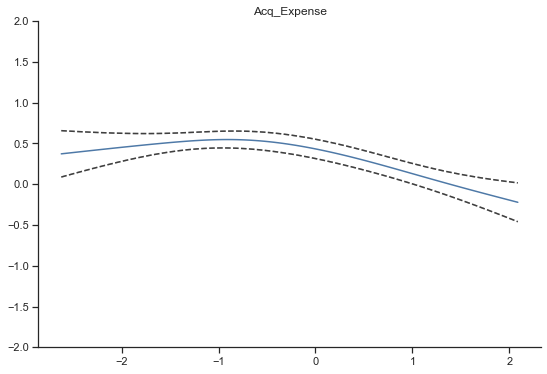

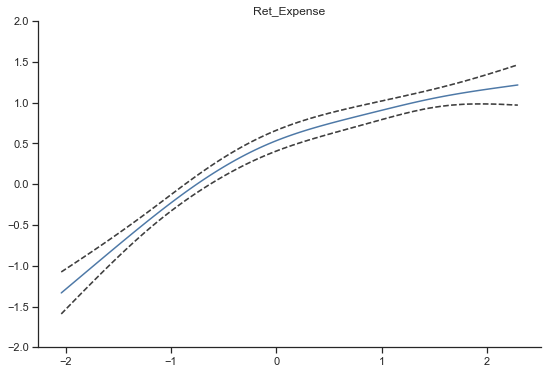

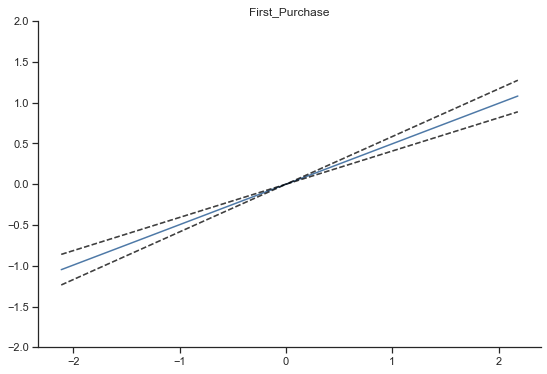

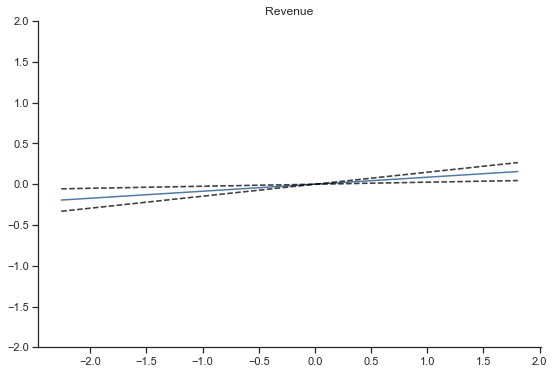

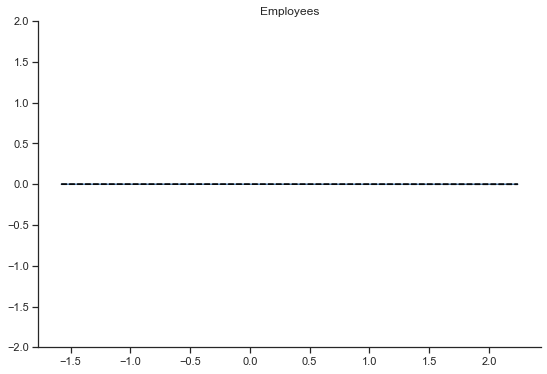

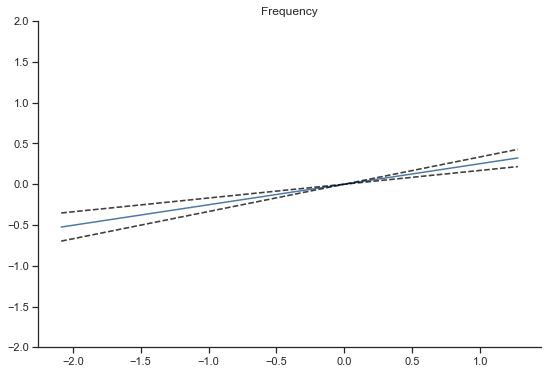

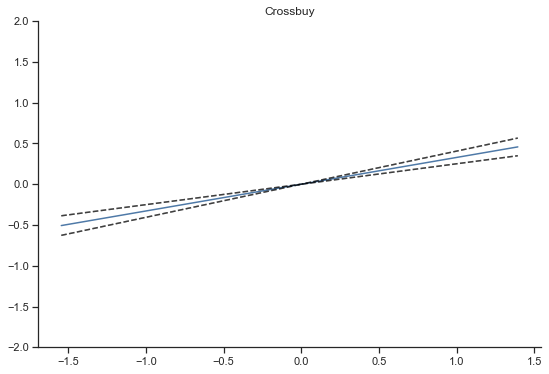

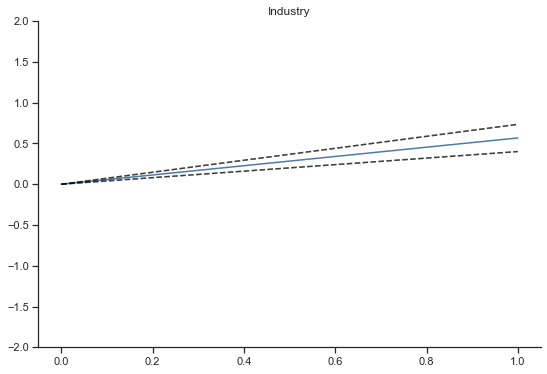

In [24]:
for j, term in enumerate(gam.terms):
    
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=j)
    pdep, confi = gam.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.ylim(-2, 2)
        
    plt.title(predictors[j])
    sns.despine()
    plt.show()

# 5. Validation results

The validation metrics suggest that we get an substantial improvement in performance by using a GAM instead of a linear regression.

Ideally, and especially because there are not many observations, it's better to use (repeated) k-fold cross-validation to compare models, with nested CV for hyperparameter optimisation.  We used a validation set here for simplicity. 

In [21]:
ols = LinearRegression()
ols.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Initialise table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['OLS', 'GAM']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, gam] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    
    y_pred = method.predict(X_valid)
    
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i, 1] = r2_score(y_valid, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_valid, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
OLS,0.539,0.661,0.415
GAM,0.440,0.774,0.313


In [101]:
import scipy

In [138]:
x = np.random.normal(size=100)
y = np.random.normal(size=100)

corr, p_value = scipy.stats.pearsonr(x, y)

In [139]:
corr, p_value

(0.12540482480140325, 0.21379557454249176)

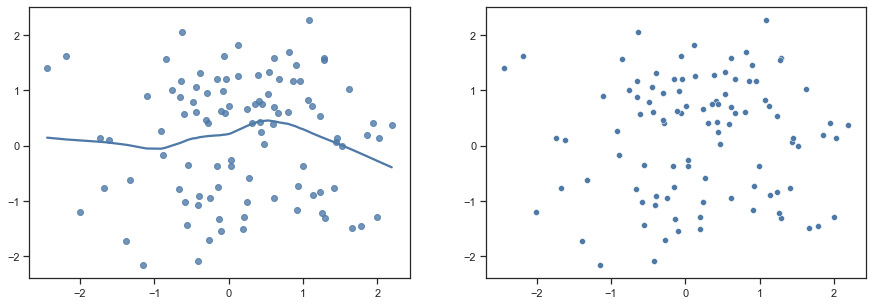

In [100]:
x = np.random.normal(size=100)
y = np.random.normal(size=100)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(x, y, lowess=True, ax=axs[0])
sns.scatterplot(x, y, ax=axs[1])

In [91]:
pd.DataFrame(np.array([x, y]).T).corr()

,0,1
0,1.000000,-0.155055
1,-0.155055,1.000000


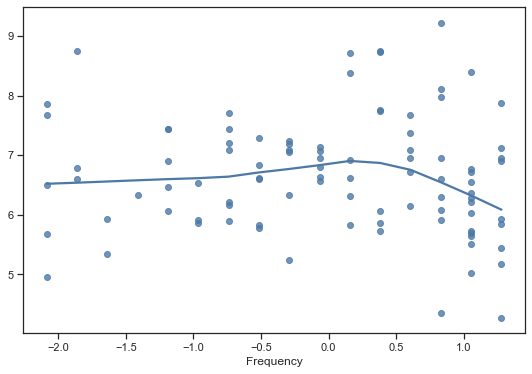

In [95]:
sns.regplot(X_train["Frequency"], y_train, lowess=True)

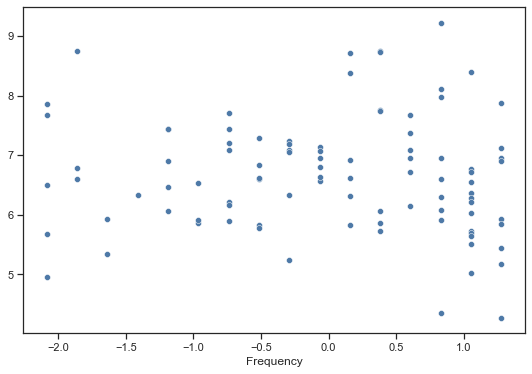

In [96]:
sns.scatterplot(X_train["Frequency"], y_train)